<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/life-is-RL/sequences/P1C4_LifeIsRL/P1C4_Sequence1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following is part of a test for an upcoming text book on computational neuroscience from an optimization and learning perspective. The book will start with evolution because ultimately, all aspects of the brain are shaped by evolution and, as we will see, evolution can also be seen as an optimization algorithm. We are sharing it now to get feedback on what works and what does not and the developments we should do.

___
# **1.4.1: Is Everything a POMDP? Yeah kind of. Can Dynamic Programming Solve Everything? Yeah Kind Of.**
## Objective:
Frame a simple problem, carefully and fully, within the Partially Observable Markov Decision Process Framework. One the one hand this framework is flexible and powerful, serving as a way of rgiourously defining almost any problem (that could be rigourously defined at all). However the formalism can be a bit invovled, even if each aspect of it has clear and intuitively accessible meaning. We're already familiar with almost all of the pieces, we just haven't put them all together like this yet. These are:

Policy: The stimulus to behaviour map that determines what an organism does.

Organism (Agent): The thing responding to stimuli and taking actions.

Environment: What generates the stimuli/preceptions the organism responds to. (Aspects of this might well be other organisms also executing their own policies!)

Reward: A measure of whether organisms actions in the environment result in a good or bad outcome for the organism. In an evolutionary context, rewards are often thought of in terms of impacts on survival, fecundity, and offspring viability.

Markov Process: A way of conceptualizing stochastic dynamics. The world is carved up into a set of possible states, and a transition function (or kernal) gives the probability of tranistioning from one state to another. Importantly, transition probabilities *are not* affected by the history of previous states. They are only determined by the currect state. This is called the Markov property, and makes analyses more tractable (though note that there is a bit of a cheat where relevant history can simply be folded into the definition of state.)

We've encountered all these before, but there is one key concept one concept that is missing, that helps tie all these together is that of **Value**.

An additional concept that we have encountered already, but not named explicitly, is the idea of **Partial Observability**. This is simply the term for situations where the full state of the environment is not known to the organism. Obviously most organisms are not omnicient, so in some sense partial observability is always the case, and often Markov decision problems are framed purely in terms of the percievable states of the organism. However, other it makes sense to seperate out the dynamics of the environment, from the dynamics of the organim's perceptual states, with the perceptual experience of the organism being determined by these 'hidden' environmental dynamics.

This all seems a bit much, but as we walk through our simple example, all of these things will actually quite straightforward, we promise.



# Setup

In [55]:
# @title Dependencies, Imports and Setup
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**
!apt install libgraphviz-dev > /dev/null 2> /dev/null #colab
!pip install ipympl pygraphviz vibecheck datatops jupyterquiz > /dev/null 2> /dev/null #google.colab

import requests
from requests.exceptions import RequestException
import numpy as np
import itertools
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.animation import FuncAnimation
import seaborn as sns
import pandas as pd
import pygraphviz as pgv
import ipywidgets as widgets
import time
import logging
import random
import os
import copy
import torch
import warnings
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from io import BytesIO
from enum import Enum
from scipy.spatial.distance import cdist
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from tabulate import tabulate
from IPython.display import display, clear_output, Markdown, HTML, Image, IFrame
from jupyterquiz import display_quiz
from vibecheck import DatatopsContentReviewContainer
from pathlib import Path
from typing import List, Dict
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
# random seed settings and
# getting torch to use gpu if it's there


def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("This notebook isn't using and doesn't need a GPU. Good.")
  else:
    print("GPU is enabled in this notebook but not needed.")
    print("If possible, in the menu under `Runtime` -> ")
    print("`Change runtime type.`  select `CPU`")

  return device


SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()


def printmd(string):
  display(Markdown(string))


# the different utility .py files used in this notebook
filenames = ['gw_plotting.py', 'gw_board.py', 'gw_game.py',
             'gw_widgets.py', 'gw_NN_RL.py']
#filenames = []
# just run the code straight out of the response, no local copies needed!
for filename in filenames:
  url = f'https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/utils/{filename}'
  response = requests.get(url)
  # Check that we got a valid response
  if response.status_code == 200:
    code = response.content.decode()
    exec(code)
  else:
    print(f'Failed to download {url}')

# environment contingent imports
try:
  print('Running in colab')
  from google.colab import output
  output.enable_custom_widget_manager()
  from google.colab import data_table
  data_table.disable_dataframe_formatter()
  #from google.colab import output as colab_output
  #colab_output.enable_custom_widget_manager()
  IN_COLAB = True
except:
  IN_COLAB = False
  print('Not running in colab')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib widget
plt.style.use("https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/pplb.mplstyle")
plt.ioff() #need to use plt.show() or display explicitly
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
    "",  # No text prompt
    notebook_section,
    {
      "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
      "name": "neuro_book",
      "user_key": "xuk960xj",
    },
  ).render()
feedback_prefix = "P1C2_S3"




################################################################
# Graph Viz Helper Functions
################################################################
# @title Graphvis Helper Functions


def latex_to_png(latex_str, file_path, dpi, fontsize, figsize):
  """Convert a LaTeX string to a PNG image."""
  fig, ax = plt.subplots(figsize=figsize)
  ax.text(0.5, 0.5, f"${latex_str}$", size=fontsize, ha='center', va='center')
  ax.axis("off")
  #plt.tight_layout()
  plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
  plt.savefig(file_path, dpi=dpi, bbox_inches='tight', transparent=True, pad_inches=0.02)
  plt.close()

def add_latex_edge_labels(graph, edge_labels, dpi=150, fontsize=16, figsize=(0.4,0.2)):
  """Add LaTeX-rendered images as edge labels using the dummy node approach."""
  for edge in edge_labels:
    src, dest, latex_str = edge
    if graph.has_edge(src, dest):
      img_path = f"{src}_to_{dest}_{latex_str}.png"
      latex_to_png(latex_str, img_path, dpi=dpi, fontsize=fontsize, figsize=figsize)
      dummy_node_name = f"dummy_{src}_{dest}_{latex_str}"
      graph.add_node(dummy_node_name, shape="box", image=img_path, label="")
      graph.delete_edge(src, dest)
      graph.add_edge(src, dummy_node_name, dir="none", weight=10)
      graph.add_edge(dummy_node_name, dest, dir="forward", weight=10)
  return graph

def set_regular_node_sizes(graph, width=1.0, height=1.0):
  """Set the size of regular nodes (excluding dummy label nodes)."""
  for node in graph.nodes():
    if not node.startswith("dummy"):
      node.attr['width'] = width
      node.attr['height'] = height
  return graph


def create_and_render_graph(nodes_list, edges_list, latex_edge_labels,
                            action_nodes = [],
                            node_colors = {},
                            node_labels = {},
                            output_path="graphviz_output.png", dpi=300,
                            figsize=(0.6, 0.3), fontsize=16):
  """
  Create a graph with given nodes, edges, and LaTeX edge labels, then render and save it.

  Parameters:
    nodes_list (list): List of nodes in the graph.
    edges_list (list): List of edges in the graph.
    latex_edge_labels (list): List of tuples containing edge and its LaTeX label.
    output_path (str): Path to save the rendered graph.
    dpi (int): DPI for rendering the graph.
    figsize (tuple): Figure size for the LaTeX labels.

  Returns:
    str: Path to the saved graph image.
  """
  # Graph Creation and Configuration
  G = pgv.AGraph(directed=True, strict=False, rankdir='LR', ranksep=0.5, nodesep=0.5)

  # Add state and decision nodes
  for node in nodes_list:
    shape = "box" if node in action_nodes else "ellipse"  # Use 'box' for decision nodes
    color = node_colors.get(node, "black")
    label = node_labels.get(node, node)
    G.add_node(node, color=color, label=label, shape=shape)

  for edge in edges_list:
    G.add_edge(edge[0], edge[1])

  # Set size for regular nodes and add LaTeX-rendered image labels to the edges
  G = set_regular_node_sizes(G, width=1, height=1)
  G = add_latex_edge_labels(G, latex_edge_labels, dpi=dpi, figsize=figsize, fontsize=fontsize)

  # Additional graph attributes
  G.graph_attr['size'] = "8,8"
  G.graph_attr['dpi'] = str(dpi)

  # Render and save the graph
  G.layout(prog='dot')
  G.draw(output_path)

  return output_path




#######################################################################
# make PatchyForageBoard class locally before integrating in shared utils
#######################################################################




class PatchyForageBoard():
  """
  A collection of methods and parameters of a patchy foraging game board that
  define the logic of the game, and allows for multiple critters on the same
  board

  game state is represented by primarily by food locations, forager locations,
  predator locations, scores, and rounds left
  food patch locations are stored on a batch x n_rows x n_cols numpy array,
  forager and predator(when we have them) locations are stored as dictionaries
  with integer keys corresponding to a forager/predatore 1, 2, 3 etc, and then
  np.argwhere style tuples of arrays of (batch_array, row_array, col_array)
  giving the locations

  scores is a batchsize x num_critters numpy array giving the scores for each
  critter on each board in the batch (note off by one indexing)

  rounds_left is how many rounds are left in the game.

  Note:
    In 2d np.array first dim is row (vertical), second dim is col (horizontal),
    i.e. top left corner is (0,0), so take care when visualizing/plotting
    as np.array visualization inline with typical tensor notation but at odds
    with conventional plotting where (0,0) is bottom left, first dim, x, is
    horizontal, second dim, y, is vertical
  """

  ARRAY_PAD_VALUE = -200

  def __init__(self, batch_size=1,
               n_rows=10, n_cols=5,
               num_foragers=1,
               max_foraging_attempts=20, # set very high for stochastic end time
               end_prob=0.05, #set to zero for strictly finite time
               moves_cost=False,
               food_patch_prob = 0.4,
               food_regen_prob=0.0,
               forage_success_prob = 0.7,
               food_extinct_prob = 0.1, rng=None):
    """Set the parameters of the game."""
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.batch_size = batch_size
    self.num_foragers = num_foragers
    self.max_foraging_attempts = max_foraging_attempts
    self.end_prob = end_prob
    self.moves_cost = moves_cost
    self.food_patch_prob = food_patch_prob
    self.forage_success_prob = forage_success_prob
    self.food_extinct_prob = food_extinct_prob
    self.food_regen_prob = food_regen_prob
    if rng is None:
      self.rng = np.random.default_rng(seed=SEED)
    else:
      self.rng = rng


  def init_loc(self, n_rows, n_cols, num, rng=None):
    """
    Samples random 2d grid locations without replacement

    Args:
      n_rows: int, number of rows in the grid
      n_cols: int, number of columns in the grid
      num:    int, number of samples to generate. Should throw an error if num > n_rows x n_cols
      rng:    instance of numpy.random's default rng. Used for reproducibility.

    Returns:
      int_loc: ndarray(int) of shape (num,), flat indices for a 2D grid flattened into 1D
      rc_index: tuple(ndarray(int), ndarray(int)), a pair of arrays with the first giving
        the row indices and the second giving the col indices. Useful for indexing into
        an n_rows by n_cols numpy array.
      rc_plotting: ndarray(int) of shape (num, 2), 2D coordinates suitable for matplotlib plotting
    """

    # Set up default random generator, use the boards default if none explicitly given
    if rng is None:
      rng = self.rng
    # Choose 'num' unique random indices from a flat 1D array of size n_rows*n_cols
    int_loc = rng.choice(n_rows * n_cols, num, replace=False)
    # Convert the flat indices to 2D indices based on the original shape (n_rows, n_cols)
    rc_index = np.unravel_index(int_loc, (n_rows, n_cols))
    # Transpose indices to get num x 2 array for easy plotting with matplotlib
    rc_plotting = np.array(rc_index).T
    # Return 1D flat indices, 2D indices for numpy array indexing and 2D indices for plotting
    return int_loc, rc_index, rc_plotting


  def get_init_board_state(self):
    """
    Set up starting board using game parameters

    Returns:
      state (dict):
      The state dictionary contains:
        - 'pieces': Current food patch locations as a batch x row x col numpy array.
        - 'scores': The current scores of the critters.
        - 'foraging_attempts': The number of foraging attempts each critter has made.
        - 'is_over': Flags indicating if the game is over for each board in the batch.
        - 'forager_locs': Dictionary of current locations of the foragers on the board.
        - 'misses_new_patch': List of counts for missed attempts at new patches for each critter.
        - 'misses_known_patch': List of counts for missed attempts at known patches for each critter.
        - 'at_new_patch': List of booleans indicating if each critter is at a new
    """
    # note that is_over applies at the batch level not the batch x forager level
    self.is_over = np.zeros(self.batch_size, dtype=bool)
    self.foraging_attempts = np.zeros((self.batch_size, self.num_foragers), dtype=int)
    self.scores = np.zeros((self.batch_size, self.num_foragers), dtype=int)
    # create an empty board array for food locs
    self.pieces = np.zeros((self.batch_size, self.n_rows, self.n_cols),
                           dtype=int)
    # Place critters in top left corner of the board
    self.forager_locs = {}
    for c in (np.arange(self.num_foragers)+1):
      self.forager_locs[c] = (np.arange(self.batch_size, dtype=int),
                              np.zeros(self.batch_size, dtype=int),
                              np.zeros(self.batch_size, dtype=int))
    # Initial food patches on the board randomly
    # each grid has an independent prob of being a pathc (to make the math
    # easier later) so total number of patches on a board is binomially
    # distributed
    num_foods = self.rng.binomial(n=self.n_rows * self.n_cols,
                                  p=self.food_patch_prob,
                                  size=self.batch_size)
    for ii in np.arange(self.batch_size):
      int_loc, rc_idx, rc_plot = self.init_loc(self.n_rows, self.n_cols,
                                               num_foods[ii])
      # food patch start locations (do each patch separate in case we
      # want to have different kinds of patches)
      for f_ in np.arange(num_foods[ii]):
        self.pieces[(ii, rc_idx[0][f_],
                         rc_idx[1][f_])] = - 1
    # keep track of which foragers have missed how many times
    # at what kind of patch
    self.misses_new_patch = np.zeros((self.batch_size, self.num_foragers), dtype=int)
    self.misses_known_patch = np.zeros((self.batch_size, self.num_foragers), dtype=int)
    self.at_new_patch = np.ones((self.batch_size, self.num_foragers), dtype=bool)
    state = {'pieces': self.pieces.copy(),
             'scores': self.scores.copy(),
             'foraging_attempts': self.foraging_attempts.copy(),
             'is_over': self.is_over.copy(),
             'forager_locs': copy.deepcopy(self.forager_locs),
             'misses_new_patch': self.misses_new_patch.copy(),
             'misses_known_patch': self.misses_known_patch.copy(),
             'at_new_patch': self.at_new_patch.copy()}
    return state


  def set_state(self, board):
    """
    Sets the state given a board dictionary.

    Args:
      board (dict):
      The board dictionary contains:
        - 'pieces': Current food patch locations as a batch x row x col numpy array.
        - 'scores': The current scores of the critters.
        - 'foraging_attempts': The number of foraging attempts each critter has made.
        - 'is_over': Flags indicating if the game is over for each board in the batch.
        - 'forager_locs': Dictionary of current locations of the foragers on the board.
        - 'misses_new_patch': List of counts for missed attempts at new patches for each critter.
        - 'misses_known_patch': List of counts for missed attempts at known patches for each critter.
        - 'at_new_patch': List of booleans indicating if each critter is at a new patch.
    """
    self.pieces = board['pieces'].copy()
    self.forager_locs = copy.deepcopy(board['forager_locs'])
    self.foraging_attempts = board['foraging_attempts'].copy()
    self.scores = board['scores'].copy()
    self.is_over = board['is_over'].copy()
    self.misses_new_patch = board['misses_new_patch'].copy()
    self.misses_known_patch = board['misses_known_patch'].copy()
    self.at_new_patch = board['at_new_patch'].copy()


  def get_state(self):
    """
    Returns the current board state.

    Returns:
      state (dict):
      The state dictionary contains:
        - 'pieces': Current food patch locations as a batch x row x col numpy array.
        - 'scores': The current scores of the critters.
        - 'foraging_attempts': The number of foraging attempts each critter has made.
        - 'is_over': Flags indicating if the game is over for each board in the batch.
        - 'forager_locs': Dictionary of current locations of the foragers on the board.
        - 'misses_new_patch': List of counts for missed attempts at new patches for each critter.
        - 'misses_known_patch': List of counts for missed attempts at known patches for each critter.
        - 'at_new_patch': List of booleans indicating if each critter is at a new patch.
    """
    state = {'pieces': self.pieces.copy(),
             'scores': self.scores.copy(),
             'foraging_attempts': self.foraging_attempts.copy(),
             'is_over': self.is_over.copy(),
             'forager_locs': copy.deepcopy(self.forager_locs),
             'misses_new_patch': self.misses_new_patch.copy(),
             'misses_known_patch': self.misses_known_patch.copy(),
             'at_new_patch': self.at_new_patch.copy()}
    return state


  ################# CORE GAME STATE UPDATE LOGIC ##############################
  ################# execute_moves is main, uses these helper functions ########


  def execute_moves(self, moves, which_critter):
    """
    Execute the moves on the board. A move to the current location implies
    foraging. If foraging, check if foraging is successful, update scores,
    and check if the food goes extinct. If moving to a new location, simply
    update the critter's location.

    Args:
      moves (tuple): A tuple of three arrays:
        - batch_array: Specifies which board in the batch the move corresponds to.
        - row_array: Specifies the target row for each move.
        - col_array: Specifies the target column for each move.
        Each array in the tuple has the same length. A move is represented by
        the combination of a batch index, row index, and column index at the
        same position in their respective arrays.
      which_critter (int): Index to identify the critter. Starts from 1.

    Returns: Nothing, just updates state related attributes of the board object

    """
    #expand moves tuple
    batch_moves, row_moves, col_moves = moves

    # Get current locations of the critter
    current_locs = self.forager_locs[which_critter]

    # Iterate over each board in the batch
    for ii in np.arange(self.batch_size):
      # If the game is over for this board, skip
      if self.is_over[ii]:
        continue

      # Get new location directly from the moves
      new_row = int(row_moves[ii])
      new_col = int(col_moves[ii])

      # Check if the critter has moved to a new patch
      if (new_row, new_col) != (current_locs[1][ii], current_locs[2][ii]):
        # Moved to a new patch
        self.misses_new_patch[ii, which_critter - 1] = 0
        self.misses_known_patch[ii, which_critter - 1] = 0
        self.at_new_patch[ii, which_critter - 1] = True
        if self.moves_cost:
          # in this variant moving also ticks down the clock
          self.foraging_attempts[ii, which_critter - 1] += 1
      # If the critter's position has not changed, it's trying to forage
      elif (new_row, new_col) == (current_locs[1][ii], current_locs[2][ii]):
        # always increment foraging attempt if foraging
        self.foraging_attempts[ii, which_critter - 1] += 1
        # Check if there's food at the location
        if self.pieces[ii, new_row, new_col] < 0:
          # Check if foraging is successful
          if self.rng.random() < self.forage_success_prob:
            # Successful foraging, increase critter's score
            self.scores[ii, which_critter - 1] += 1
            # misses are zeroed and no longer at new patch
            self.misses_new_patch[ii, which_critter - 1] = 0
            self.misses_known_patch[ii, which_critter - 1] = 0
            self.at_new_patch[ii, which_critter - 1] = False
            # Check if food goes extinct (only on success)
            if self.rng.random() < self.food_extinct_prob:
              self.pieces[ii, new_row, new_col] = 0  # Set it to empty
          else:
            #unsuccessful foraging at patch with food
            if self.at_new_patch[ii, which_critter - 1]:
              # at a new patch
              self.misses_new_patch[ii, which_critter - 1] += 1
            else:
              # at a known patch
              self.misses_known_patch[ii, which_critter - 1] += 1
        else:
          #unsuccessful foraging at patch without food
            if self.at_new_patch[ii, which_critter - 1]:
              # at a new patch
              self.misses_new_patch[ii, which_critter - 1] += 1
            else:
              # at a known patch
              self.misses_known_patch[ii, which_critter - 1] += 1

      # Always check if session is over, can end by hitting a fixed
      # horizon or by
      if self.foraging_attempts[ii] >= self.max_foraging_attempts:
        self.is_over[ii] = True
      elif self.rng.random() < self.end_prob:
        self.is_over[ii] = True

    # assume moves are legal and update locs for whole batch at once
    self.forager_locs[which_critter] = (batch_moves, row_moves, col_moves)

  ###### Getting Legal Moves and Perceptions #########################
  ####################################################################
  def get_neighbor_grc_indices(self, which_critter, radius, pad=False):
    """
    Returns all grid positions within a certain cityblock distance radius from
    the place corresponding to which_critter.

    Args:
        which_critter (int): The idex of the focal critter_food.
        radius (int): The cityblock distance.
        pad (bool): whether or not to pad the array, if padded all row, col
          indexes are valid for the padded array, useful for getting percept
          if not all indexes are correct for the original array, useful for
          figuring out legal moves.

    Returns:
        an array of indices, each row is a g, r, c index for the neighborhoods
        around the critters, can use the g value to know which board you are in.
        if pad=True also returns the padded array (the indices in that case) are
        for the padded array, so won't work on self.pieces, whereas if pad is
        False the indices will be for the offsets in reference to the original
        self.pieces, but note that some of these will be invalid, and will
        need to be filtered out (as we do in get_legal)
    """
    batch_size, n_rows, n_cols = self.pieces.shape
    batch, rows, cols = self.forager_locs[which_critter]
    # Create meshgrid for offsets
    if pad is True:
      padded_arr = np.pad(self.pieces, ((0, 0), (radius, radius),
        (radius, radius)), constant_values=self.ARRAY_PAD_VALUE)
      rows = rows + radius
      cols = cols + radius

    row_offsets, col_offsets = np.meshgrid(
        np.arange(-radius, radius + 1),
        np.arange(-radius, radius + 1),
        indexing='ij')

    # Filter for valid cityblock distances
    mask = np.abs(row_offsets) + np.abs(col_offsets) <= radius
    valid_row_offsets = row_offsets[mask]
    valid_col_offsets = col_offsets[mask]
    # Extend rows and cols dimensions for broadcasting
    extended_rows = rows[:, np.newaxis]
    extended_cols = cols[:, np.newaxis]
    # Compute all neighbors for each position in the batch
    neighbors_rows = extended_rows + valid_row_offsets
    neighbors_cols = extended_cols + valid_col_offsets

    indices = np.column_stack((np.repeat(np.arange(batch_size),
                                         neighbors_rows.shape[1]),
                               neighbors_rows.ravel(),
                               neighbors_cols.ravel()))
    if pad is False:
      return indices
    elif pad is True:
      return indices, padded_arr


  def get_legal_moves(self, which_critter, radius=1):
    """
    Identifies all legal moves for the critter.

    Returns:
      A numpy int array of size batch x 3(g,x,y) x 4(possible moves)

    Note:
      moves[0,1,3] is the x coordinate of the move corresponding to the
      fourth offset on the first board.
      moves[1,:,1] will give the g,x,y triple corresponding to the
      move on the second board and the second offset, actions are integers
    """

    critter_locs = np.array(self.forager_locs[which_critter])
    # turn those row, col offsets into a set of legal offsets
    legal_offsets = self.get_neighbor_grc_indices(which_critter, radius)
    legal_offsets = {tuple(m_) for m_ in legal_offsets}

    legal_destinations = np.where(np.ones(self.pieces.shape, dtype=bool))
    legal_destinations = {tuple(coords) for coords in zip(*legal_destinations)}
    # Add the current locations of the critters to legal_destinations
    current_locations = {tuple(loc) for loc in critter_locs.T}
    legal_destinations = legal_destinations.union(current_locations)

    # legal moves are both legal offsets and legal destinations
    legal_moves = legal_offsets.intersection(legal_destinations)
    return legal_moves


  def get_perceptions(self, critter_food, radius):
    idx, pad_pieces = self.get_neighbor_grc_indices(critter_food,
                                                    radius, pad=True)
    #percept_mask = np.zeros(pad_pieces.shape, dtype=bool)
    #percept_mask[idx[:,0], idx[:,1]], idx[:,2]] = True
    percept = pad_pieces[idx[:,0], idx[:,1], idx[:,2]]
    return(percept.reshape(self.batch_size, -1))




#######################################################################
# make PatchyForageGame class locally before integrating in shared utils
#######################################################################
# @title PatchyForageGame class




class PatchyForagingGame():
  """
  A collection of methods and parameters of a patchy foraging game that allow
  for interaction with and display of PatchyForageBoard objects.
  """


  def __init__(self, batch_size=1, n_rows=10, n_cols=5, num_foragers=1,
               max_foraging_attempts=20,
               end_prob = 0.05,
               moves_cost=False,
               food_patch_prob=0.3, food_regen_prob=0.0,
               forage_success_prob=0.6, food_extinct_prob=0.2, rng=None):
    """
    Initializes an instance of the PatchyForagingGame with the specified parameters.
    Args:
    ... [same as in PatchyForageBoard]
    """
    self.board_params = {
      'batch_size': batch_size,
      'n_rows': n_rows,
      'n_cols': n_cols,
      'num_foragers': num_foragers,
      'max_foraging_attempts': max_foraging_attempts,
      'end_prob': end_prob,
      'moves_cost': moves_cost,
      'food_patch_prob': food_patch_prob,
      'forage_success_prob': forage_success_prob,
      'food_extinct_prob': food_extinct_prob,
      'food_regen_prob': food_regen_prob,
      'rng': rng if rng is not None else np.random.default_rng(seed=SEED)
    }

  def get_init_board(self):
    """
    Generates a starting board given the parameters of the game.
    Returns the initial state of the game.
    """
    board = PatchyForageBoard(**self.board_params)
    return board.get_init_board_state()


  def get_board_shape(self):
    """Shape of a single board, doesn't give batch size"""
    return (self.board_params['n_rows'], self.board_params['n_cols'])

  def get_action_size(self):
    """
    Returns the number of all possible actions, even though only a subset
    of these will ever be valid on a given turn.
    Actions correspond to integer indexes of board locations,
    moves to (batch,) row and column coordinate indexes of board locations.
    """
    return self.board_params['n_rows'] * self.board_params['n_cols']

  def get_batch_size(self):
    return self.board_params['batch_size']

  def get_scores(self, board):
    return board['scores'].copy()

  def get_foraging_attempts(self, board):
    return board['foraging_attempts'].copy()

  def get_square_symbol(self, piece, has_forager):
    """Returns the symbol representation of a board square."""
    if has_forager and piece < 0: return 'C'  # Critter on food patch
    if has_forager: return 'P'  # Forager on an empty square
    if piece == 0: return '.'  # Empty square
    if piece < 0: return 'F'  # Food patch
    return '?'  # Unknown piece type, for debugging

  def display(self, board, g=0):
    """Displays the g-th game in the batch of boards."""
    print("   ", end="")
    for c_ in range(self.n_cols):
      print(c_, end=" ")
    print("")
    print("-----------------------")
    for r_ in range(self.n_rows):
      print(r_, "|", end="")  # Print the row number
      for c_ in range(self.n_cols):
        piece = board['pieces'][g, r_, c_]  # Get the piece to print
        # Check if the square is occupied by a forager
        has_forager = False
        for forager_num, locs in board['forager_locs'].items():
          if g in locs[0] and r_ in locs[1] and c_ in locs[2]:
            has_forager = True
            break

        print(self.get_square_symbol(piece, has_forager), end=" ")
      print("|")
    print("-----------------------")
    print("Foraging Attempts: " + str(board['foraging_attempts'][g]))
    print("Score: " + str(board['scores'][g]))

  def get_critter_rc(self, board, g, which_critter):
    critter_locs = board['forager_locs'][which_critter]
    return critter_locs[1][g], critter_locs[2][g]

  def plot_board(self, board, g=0,
                 fig=None, ax=None, critter_specs=None, food=None, fov=None,
                 legend_type='included',
                 has_fov=False, #fog_of_war field_of_view
                 fov_opaque=False, #let human see through fog of war or not
                 show_food=True,
                 radius=2, figsize=(6,5), title=None,
                 name='Critter',
                 focal_critter_index = 0):
    """Uses plotting functions to make picture of the current board state"""
    batch_size, n_rows, n_cols = board['pieces'].shape
    num_foragers = self.board_params['num_foragers']
    plt.ioff()
    if fig is None and ax is None:
      fig, ax = make_grid(n_rows, n_cols, figsize=figsize, title=title)

    # get food locs and plot them
    rc_food_index = np.array(np.where(board['pieces'][g] <= -1))
    rc_food_plotting = np.array(rc_food_index).T
    if food is None:
      food = plot_food(fig, ax, rc_food_plotting, size=550, show_food=show_food)
    else:
      food = plot_food(fig, ax, rc_food_plotting, food, show_food=show_food)

    # generate critter plotting specs if we don't already have them
    if critter_specs is None:
      critter_specs = []
      markers = ['h', 'd']  # hexagon and diamond
      colors = sns.color_palette("colorblind")
      for i in range(num_foragers):
        critter_name = name if num_foragers == 1 else f'{name} {i+1}'
        spec = {'marker': markers[i % len(markers)],
                'color': colors[i // len(markers) % len(colors)],
                'name': critter_name,
                'int_id': i+1}
        critter_specs.append(spec)
    # get critter locs and plot them
    assert len(critter_specs) == num_foragers, "More/fewer specs than critters"
    for spec in critter_specs:
      rc_loc = np.array(self.get_critter_rc(board, g, spec['int_id'])).T
      spec.update({'rc_loc': rc_loc})
    critter_specs = plot_critters(fig, ax, critter_specs)

    #plot field of view if doing that
    if has_fov:
      # plot field of view around the 'active player'
      if fov is None:
        fov = plot_fov(fig, ax, critter_specs[focal_critter_index]['rc_loc'][0],
                       n_rows, n_cols, radius, has_fov, opaque=fov_opaque)
      else:
        fov = plot_fov(fig, ax, critter_specs[focal_critter_index]['rc_loc'][0],
                       n_rows, n_cols, radius, has_fov, opaque=fov_opaque, fov=fov)
    # make legend and draw and return figure
    if legend_type == 'included':
      fig.legend(loc = "outside right upper", markerscale=0.8)
      fig.canvas.draw()
      return fig, ax, critter_specs, food, fov
    elif legend_type == 'separate':
      fig_legend, ax_legend = plt.subplots(figsize=(1.5,1.5), layout='constrained')
      fig_legend.get_layout_engine().set(w_pad=0, h_pad=0, hspace=0, wspace=0)
      handles, labels = ax.get_legend_handles_labels()
      ax_legend.legend(handles, labels, loc='center', markerscale=0.8)
      ax_legend.axis('off')
      fig_legend.canvas.header_visible = False
      fig_legend.canvas.toolbar_visible = False
      fig_legend.canvas.resizable = False
      fig_legend.canvas.footer_visible = False
      fig_legend.canvas.draw()
      return fig, ax, critter_specs, food, fov, fig_legend, ax_legend
    else: #no legend
      fig.canvas.draw()
      return fig, ax, critter_specs, food, fov


  def get_legal_moves(self, board, which_critter=1, radius=1):
    """
    A Helper function to get the legal moves, as a set of batch, row, col triples
    for the given board. Does return moves that are technically legal
    but that will result in a blocking move

    Args:
      board: a dictionary containing
        - 'pieces': Current food patch locations as a batch x row x col numpy array.
        - 'scores': The current scores of the critters.
        - 'foraging_attempts': The number of foraging attempts each critter has made.
        - 'is_over': Flags indicating if the game is over for each board in the batch.
        - 'forager_locs': dictionary of current locations of the foragers on the board.

      which_critter (int): value of critter we are getting the valid actions for
      radius (int): how far, in city block distance the critter can move

    Returns:
      moves: set or tuples (g, r, c)
    """
    b = PatchyForageBoard(**self.board_params)
    b.set_state(board)
    legal_moves =  b.get_legal_moves(which_critter, radius)
    return legal_moves

  def get_valid_actions(self, board, which_critter=1, radius=1):
    """
    A Helper function to translate the g,x,y, tuples provided the
    get_legal_moves method into valid actions, represented
    as binary vectors of len num_actions.

    Args:
      board: a dictionary containing
        - 'pieces': Current food patch locations as a batch x row x col numpy array.
        - 'scores': The current scores of the critters.
        - 'foraging_attempts': The number of foraging attempts each critter has made.
        - 'is_over': Flags indicating if the game is over for each board in the batch.
        - 'forager_locs': dictionary of current locations of the foragers on the board.
      which_critter (int): value of critter we are getting the valid actions for
      radius (int): how far, in city block distance the critter can move

    Returns:
      valids: np.ndarray(binary) batch_size x num_actions, 1's represent
              valid moves
    """
    legal_moves =  self.get_legal_moves(board, which_critter, radius)
    g, r, c = zip(*legal_moves)
    valids = np.zeros((self.batch_size, self.n_rows * self.n_cols))
    valids[g, np.array(r) * self.n_cols + np.array(c)] = 1
    return valids


  def get_next_state(self, board, which_critter, actions):
    """
    Helper function using GridworldBoard.execute_moves to update board state
    given actions on a batch of boards, for a given critter

    Args:
      board: a dictionary containing
        - 'pieces': Current food patch locations as a batch x row x col numpy array.
        - 'scores': The current scores of the critters.
        - 'foraging_attempts': The number of foraging attempts each critter has made.
        - 'is_over': Flags indicating if the game is over for each board in the batch.
        - 'forager_locs': dictionary of current locations of the foragers on the board.
      which_critter: integer index of the critter type
      actions: list of flat integer indexes of critter's new board positions

    Returns:
      a board triple signifying next state

    Note:
      if len(actions) > batch_size of board the returned board state will have
      an expanded batch size, allowing multiple paths in the game tree to be
      explored in parallel

    """
    assert self.board_params['batch_size'] == len(actions)
    b = PatchyForageBoard(**self.board_params)
    b.set_state(board)
    moves = self.actions_to_moves(actions)
    b.execute_moves(moves, which_critter)
    return b.get_state()

  def actions_to_moves(self, actions):
    """
    Args:
      actions: a batch length list of integer indexes for the flattened boards,
      i.e. in the range(n_cols * n_rows) actions are often much easier to use
      as training targets for NN based RL agents.
    Returns
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new row coord for each critter
        on each board and the third gives the new col coord. Note this is
        exactly the format expected by GridworldBoard.execute_moves, and
        is a canonical way of indexing arrays for quick numpy operations.
    """
    moves = (np.arange(len(actions)),
             np.floor_divide(actions, self.n_cols),
             np.remainder(actions, self.n_cols))
    return moves

  def moves_to_actions(self, moves):
    """
    Args:
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new row coord for each critter
        on each board and the third gives the new col coord. Note this is
        exactly the format expected by GridworldBoard.execute_moves, and
        is a canonical way of indexing arrays for quick numpy operations.
    Returns:
      actions: a batch length list of integer indexes for the flattened boards,
      i.e. in the range(n_cols * n_rows) actions are often much easier to use
      as training targets for NN based RL agents.
    """
    _, rows, cols = moves
    actions = rows * self.n_cols + cols
    return actions

  def critter_oriented_get_next_state(self, board, which_critter, offsets):
    """
    Translates directions in reference to the critter's location into
    moves on the board in absolute terms, while checking for
    bouncing/reflecting then get's the next state.

    Args:
      board: a dictionary containing
        - 'pieces': Current food patch locations as a batch x row x col numpy array.
        - 'scores': The current scores of the critters.
        - 'foraging_attempts': The number of foraging attempts each critter has made.
        - 'is_over': Flags indicating if the game is over for each board in the batch.
        - 'forager_locs': dictionary of current locations of the foragers on the board.
      which_critter: integer index of the critter type
      offsets: batch length list of strings one 'up', 'down', 'left', 'right' 'still'

    Returns:
      a board triple signifying next state

    Note:
      Unlike get_next_state, this method does not allow for expansion
      of the game tree, i.e. len(offsets)==batch_size required
    """
    assert len(offsets) == self.board_params['batch_size']
    b = PatchyForageBoard(**self.board_params)
    b.set_state(board)
    moves = self.critter_direction_to_move(board, offsets, which_critter)
    b.execute_moves(moves, which_critter)
    return(b.get_state())

  def critter_direction_to_move(self, board, offsets, critter):
    """
    Translates directions in reference to the critter's location into
    moves on the board in absolute terms, while checking for
    bouncing/reflecting then returns moves. Doesn't check for collisions with
    other critters though. In general player's move methods should be checking
    valid moves and only making legal ones.

    Args:
      board: a dictionary containing
        - 'pieces': Current food patch locations as a batch x row x col numpy array.
        - 'scores': The current scores of the critters.
        - 'foraging_attempts': The number of foraging attempts each critter has made.
        - 'is_over': Flags indicating if the game is over for each board in the batch.
        - 'forager_locs': dictionary of current locations of the foragers on the board.
      which_critter: integer index of the critter type
      offsets: batch length list of strings,
        one of 'up', 'down', 'left', 'right', 'still'

    Returns:
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new row coord for each critter
        on each board and the third gives the new col coord. Note this is
        exactly the format expected by GridworldBoard.execute_moves, and
        is a canonical way of indexing arrays for numpy.
    """
    assert len(offsets) == board['pieces'].shape[0]
    batch_size, n_rows, n_cols = board['pieces'].shape
    offset_dict = {'up': (0, -1, 0),
                   'down': (0, 1, 0),
                   'left': (0, 0, -1),
                   'right': (0, 0, 1),
                   'still': (0, 0, 0)}
    this_critter_locs = board['forager_locs'][critter]
    all_critter_locs = np.where(board['pieces'] >= 1)
    offsets_array = np.hstack([np.array(offset_dict[ost_]).reshape((3,1))
                           for ost_ in offsets])
    new_locs = np.array(this_critter_locs) + offsets_array
    #check bounces at boundaries
    new_locs[1,:] = np.where(new_locs[1] >=
                               n_rows, n_rows-2, new_locs[1])
    new_locs[2,:] = np.where(new_locs[2,:] >=
                               n_cols, n_cols-2, new_locs[2,:])
    new_locs[1,:] = np.where(new_locs[1,:] < 0, 1, new_locs[1,:])
    new_locs[2,:] = np.where(new_locs[2,:] < 0, 1, new_locs[2,:])
    moves = tuple(new_locs)
    return moves

  def critter_directions_to_actions(self, board, directions, critter):
    """
    Converts a list of direction strings to a list of action indices for the given board state and critter.

    Args:
      board (dict): The current state of the game.
      directions (list of str): List of directions, where each direction is one of 'up', 'down', 'left', 'right', 'still'.
      critter (int): The critter index.

    Returns:
      list of int: List of action indices corresponding to the directions.
    """
    # Ensure the length of directions matches the batch size
    assert len(directions) == board['pieces'].shape[0], "Mismatch between directions length and batch size"

    # Convert directions to moves
    moves = self.critter_direction_to_move(board, directions, critter)

    # Convert moves to actions
    actions = self.moves_to_actions(moves)

    return actions


  def get_valid_directions(self, board, which_critter):
    """
    Transforms output of get_valid_actions to a list of the valid directions
    for each board in the batch for a given critter.
    """
    offset_dict = {( 0, 1): 'right',
                   ( 0,-1): 'left',
                   ( 1, 0): 'down',
                   (-1, 0): 'up',
                   ( 0, 0): 'still'}
    batch_size, n_rows, n_cols = board['pieces'].shape
    valid_actions = self.get_valid_actions(board, which_critter)
    if batch_size != len(valid_actions):
      raise ValueError("Need Exactly one set of valid actions per board in batch")
    critter_locs = board['forager_locs'][which_critter]
    valid_directions = []
    for g, batch_valid in enumerate(valid_actions):
      valid_int_indices = np.where(batch_valid==1)[0]
      critter_loc = np.array([[critter_locs[1][g],critter_locs[2][g]]])
      # critter_loc shape is (1, 2)
      moves = np.column_stack([valid_int_indices // n_cols, valid_int_indices % n_cols])
      offsets = moves - critter_loc
      batch_valid_directions = [offset_dict[tuple(offset)] for offset in offsets]
      valid_directions.append(batch_valid_directions)
    return valid_directions


  def get_perceptions(self, board, radius, which_critter):
    b = PatchyForageBoard(**self.board_params)
    b.set_state(board)
    return(b.get_perceptions(radius, which_critter))


  def play_game(self, players=[], visualize = False):
    """This method takes a list of players the same length as num_foragers,
        and then plays a batch of games with them and returns the final board
        states of each game"""
    if len(players) != self.num_foragers:
      raise ValueError("number of players different than expected")

    board = self.get_init_board()
    if visualize == True:
      self.display(board, 0)

    for p_idx, player_ in enumerate(players):
      if player_.critter_index != p_idx+1:
        print(player_.critter_index)
        print(p_idx + 1)
        raise ValueError("player order does not match assigned critter index")

    while np.any(board['is_over'] == False):
      for player_ in players:
        old_scores = board['scores']
        if player_.return_direction:
          directions = player_.play(board)
          a_player = self.critter_directions_to_actions(board, directions, player_.critter_index)
        else: # player returns actions directly
          a_player, _, _ = player_.play(board)
        board = self.get_next_state(board, player_.critter_index, a_player)
        if visualize == True:
          self.display(board, 0)
    return board


  def plot_visualizations(board):
    # Extracting scores and foraging_attempts for all batches
    scores = board['scores']
    foraging_attempts = board['foraging_attempts']

    # Calculating average scores per round for each batch
    avg_scores_per_round = scores / foraging_attempts

    # Histogram of Average Score Per Round
    plt.figure()
    plt.hist(avg_scores_per_round, bins=30, edgecolor='black')
    plt.xlabel('Average Score Per Round')
    plt.ylabel('Frequency')
    plt.title('Histogram of Average Score Per Round')
    plt.show()

    # Scatter Plot of Averages vs. Foraging Attempts
    plt.figure()
    plt.scatter(foraging_attempts, avg_scores_per_round, c='blue', alpha=0.5)
    plt.xlabel('Foraging Attempts')
    plt.ylabel('Average Score Per Round')
    plt.title('Scatter Plot of Average Scores vs. Foraging Attempts')
    plt.grid(True)
    plt.show()





#######################################################################
# make InteractivePatchyForage class locally before integrating in shared utils
#######################################################################
# @title Interactive Patchy Foraging




class InteractivePatchyForage():
  """
  A widget based object for interacting with a gridworld game
  """

  def __init__(self, PatchyForage_game, init_board=None, has_fov=False,
               radius=2, fov_opaque=False, show_food=True, show_misses=False,
               figsize=(6,5), critter_names=['Critter'], players=['human']):
    """
    Initializes a widget based object for interacting with a patchy foraging game

    Args:
      gridworld_game: an instance of PatchyForageGame object
        expects this to have batchsize 1
      init_board: (optional) a dictionary containing
        - 'pieces': Current food patch locations as a batch x row x col numpy array.
        - 'scores': The current scores of the critters.
        - 'foraging_attempts': The number of foraging attempts each critter has made.
        - 'is_over': Flags indicating if the game is over for each board in the batch.
        - 'forager_locs': dictionary of current locations of the foragers on the board.
      has_fov: bool, whether or not to display fog of war around the critter
      radius: int, number of squares the critter can "see" around it
      figsize: tuple (int, int), size of the figure
      critter_names: a list of strings that determines what the critter is called
        in the plot legend, order should align with players
      player: a list of either 'human', None, or a player object with a play
        method and a critter_index attribute. If 'human' use buttons,  if None
        default to making a RandomValidPlayer object, otherwise use the
        player class provided to make the player objects and use a start button.
        The list needs to be as long as the PatchyForage_game.num_foragers
        attribute. Order should align with critter_name.

      Note: fov only turns on for the 'active' player.
    """

    # Set GridworldGame object and initialize the board state
    self.pfg = PatchyForage_game
    self.num_foragers = self.pfg.board_params['num_foragers']
    self.moves_cost = self.pfg.board_params['moves_cost']
    self.has_fov = has_fov
    self.radius = radius
    self.fov_opaque = fov_opaque
    self.show_food = show_food
    self.percept_len = 2*self.radius*(self.radius+1)
    self.figsize = figsize
    # initialize players and plotting specs together to ensure alignment
    self.players = []
    self.any_human_players = False
    self.active_player_index = 0
    self.crit_specs = []
    markers = ['h', 'd']  # hexagon and diamond
    colors = sns.color_palette("colorblind")
    for i in range(self.num_foragers):
      spec = {'marker': markers[i % len(markers)],
              'color': colors[i // len(markers) % len(colors)],
              'name': critter_names[i],
              'int_id': i+1}
      self.crit_specs.append(spec)
      player = players[i] #implicit check that players is at least long enough
      if player is None:
        self.players.append(RandomValidPlayer(self.gwg, critter_index=i+1))
      elif player == 'human':
        self.players.append('human')
        # right now only ever have on human player with index 1
        self.any_human_players = True
      else:
        # player objects expected to have a critter_index attribute
        # we set it appropriately here so it aligns with the players list
        # used to create the widget
        player.critter_index = i+1
        self.players.append(player)
    self.final_scores = []
    # Initialize the sidebar for displaying misses if needed
    self.show_misses = show_misses
    if self.show_misses:
      self.misses_sidebar = widgets.Output(layout=widgets.Layout(
          min_width='12.5em', max_width='18.8em',
          min_height='6.3em', overflow='auto'))
      self.misses_new_patch = [0] * self.num_foragers
      self.misses_known_patch = ['--'] * self.num_foragers
      self.at_new_patch = [True] * self.num_foragers

    if init_board is None:
      self.board_state = self.pfg.get_init_board()
    else:
      self.board_state = init_board
    # Initialize widgets and buttons
    self.output = widgets.Output(layout=widgets.Layout(
      width = '20.0em', min_width='20.0em', max_width='21.0em',
      min_height='10.0em', overflow='auto'))
    self.scoreboard = widgets.Output(layout=widgets.Layout(
      min_width='12.5em', max_width='18.8em',
      min_height='6.3em', overflow='auto'))
    self.up_button = widgets.Button(description="Up",
      layout=widgets.Layout(width='6.3em'))
    self.down_button = widgets.Button(description="Down",
      layout=widgets.Layout(width='6.3em'))
    self.left_button = widgets.Button(description="Left",
      layout=widgets.Layout(width='6.3em'))
    self.right_button = widgets.Button(description="Right",
      layout=widgets.Layout(width='6.3em'))
    self.forage_button = widgets.Button(description="Forage",
      layout=widgets.Layout(width='6.3em'))
    self.start_button = widgets.Button(description="Start",
      layout=widgets.Layout(width='6.3em'))
    self.empty_space = widgets.Box(layout=widgets.Layout(height='2.5em'))

    # get plot canvas widgets and other plotting objects
    plt.ioff()
    if len(self.players) > 1:
      self.legend_type=None # don't keep regenerating the legend
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov,
       self.b_fig_legend, self.b_ax_legend) = self.pfg.plot_board(
          self.board_state, g=0, critter_specs=self.crit_specs,
          has_fov=self.has_fov, legend_type='separate',
          radius=self.radius, fov_opaque=self.fov_opaque, figsize=self.figsize,
          show_food=self.show_food)
    else:
      self.legend_type = 'included'
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
        ) = self.pfg.plot_board(self.board_state, g=0,
                                critter_specs=self.crit_specs,
                                has_fov=self.has_fov,
                                fov_opaque=self.fov_opaque,
                                show_food=self.show_food,
                                radius=self.radius, figsize=self.figsize)
    # lump buttons together
    self.buttons = widgets.HBox([widgets.VBox([self.forage_button, self.left_button]),
                                 widgets.VBox([self.up_button, self.down_button]),
                                 widgets.VBox([self.empty_space, self.right_button])])
    # automatically pick different layouts for different situations
    if self.any_human_players:
      self.board_and_buttons = widgets.VBox([self.b_fig.canvas,
                                             self.buttons])
      if len(self.players) == 1:
        #one human player
        self.output_and_score = widgets.VBox([self.scoreboard, self.output])
        if self.show_misses:
            self.final_display = widgets.HBox([self.board_and_buttons,
                widgets.VBox([self.misses_sidebar, self.output_and_score])])
        else:
            self.final_display = widgets.VBox([self.board_and_buttons,
                                               self.output_and_score])
      else:
        # more than one player, one of them human
        self.V_board_output= widgets.VBox([self.board_and_buttons,
                                             self.output])
        self.V_scoreboard_start_legend = widgets.VBox([
        self.scoreboard, self.start_button, self.b_fig_legend.canvas])
        if self.show_misses:
          self.final_display = widgets.HBox([self.V_board_output,
                                             self.V_scoreboard_start_legend,
                                             self.misses_sidebar])
        else:
          self.final_display = widgets.HBox([self.V_board_output,
                                             self.V_scoreboard_start_legend])
    else: # all players are ai
      if len(self.players) == 1:
        # one ai player
        if self.show_misses:
          self.final_display = widgets.HBox(
              [widgets.VBox([self.b_fig.canvas, self.scoreboard]),
               widgets.VBox([self.misses_sidebar, self.output,
                             self.start_button])])
        else:
          self.H_score_output_start = widgets.HBox([
            self.scoreboard, self.output, self.start_button])
          self.final_display = self.HBox(
              [widgets.VBox([self.b_fig.canvas, self.H_score_output_start])])
      else:
        # more than one ai player
        self.V_board_output = widgets.VBox([self.b_fig.canvas, self.output])
        self.V_scoreboard_start_legend = widgets.VBox([
          self.scoreboard, self.start_button, self.b_fig_legend.canvas])
        if self.show_misses:
          self.final_display = widgets.HBox([self.V_board_output,
                                             self.V_scoreboard_start_legend,
                                             self.misses_sidebar])
        else:
          self.final_display = widgets.HBox([self.V_board_output,
                                             self.V_scoreboard_start_legend])
    # initialize text outputs
    with self.scoreboard:
      table = [['Best Eating Rate:'] + ['--'] * self.num_foragers,
               ['Last Eating Rate:'] + ['--'] * self.num_foragers,
               ['Average Eating Rate:'] + ['--'] * self.num_foragers,]
      if len(self.players) > 1:
        headers = [''] + [f'P{i+1}' for i in range(self.num_foragers)]
        print(tabulate(table, headers=headers))
      else: # len(self.players) == 1
        print(tabulate(table))
    with self.output:
      if self.any_human_players:
        print('Click a button to start playing')
      else:
        print('Click the start button to run the simulation')
    # If show_misses is enabled, initialize the misses_sidebar content
    if self.show_misses:
      with self.misses_sidebar:
        table = [['Misses (New Patch):'] + ['0'] * self.num_foragers,
                 ['Misses (Known Patch):'] + ['--'] * self.num_foragers]
        if len(self.players) > 1:
          headers = [''] + [f'P{i+1}' for i in range(self.num_foragers)]
          print(tabulate(table, headers=headers))
        else: # len(self.players) == 1
            print(tabulate(table))

    # Connect the buttons to functions that do something
    self.up_button.on_click(self.on_up_button_clicked)
    self.down_button.on_click(self.on_down_button_clicked)
    self.left_button.on_click(self.on_left_button_clicked)
    self.right_button.on_click(self.on_right_button_clicked)
    self.forage_button.on_click(self.on_forage_button_clicked)
    self.start_button.on_click(self.on_start_button_clicked)


  def update_state_based_on_move(self, direction):
    old_board = self.board_state.copy()
    # index of players is 0 through num_critter-1,
    # same player represented by value of index + 1 in
    if (isinstance(self.players[self.active_player_index], str) and
        'human' in self.players[self.active_player_index]):
      direction = direction
    else:
      if self.players[self.active_player_index].return_direction:
        directions = self.players[self.active_player_index].play(old_board)
      else:
        a_player, _, _ = self.players[self.active_player_index].play(old_board)
        # print(a_player)
        directions = self.pfg.action_to_critter_direction(old_board,
                                                        self.active_player_index+1,
                                                        a_player)
      # but we only want to apply their move to the appropriate board
      direction = directions[0]
    self.board_state = self.pfg.critter_oriented_get_next_state(
          self.board_state, self.active_player_index+1, [direction])
    return direction


  def update_output_and_scores(self, direction, old_board):
    old_scores = old_board['scores'][0]
    old_row, old_col = self.pfg.get_critter_rc(old_board, 0,
                                               self.active_player_index+1)
    new_scores = self.board_state['scores'][0] #first batch first critter type
    foraging_attempts = self.board_state['foraging_attempts'][0]
    row, col = self.pfg.get_critter_rc(self.board_state, 0,
                                       self.active_player_index+1)

    did_eat = False
    # Check if the forager moved or tried to forage and what happened
    if (row, col) != (old_row, old_col):
      # Moved to a new patch
      self.misses_new_patch[self.active_player_index] = 0
      self.misses_known_patch[self.active_player_index] = '--'
      self.at_new_patch[self.active_player_index] = True
      action_string = "tried to move " + direction + " to ({}, {})".format(row, col)
      eating_string = "They were too busy moving to look for food."
    elif (row, col) == (old_row, old_col):
      # they didn't move, tried to forage
      action_string = "tried to forage."
      if new_scores[self.active_player_index] > old_scores[self.active_player_index]:
        # They found food
        eating_string = "They found some food at the patch!"
        did_eat = True
        if self.at_new_patch[self.active_player_index]:
          # They found food at a new patch
          self.misses_new_patch[self.active_player_index] = '--'
          self.misses_known_patch[self.active_player_index] = 0
          self.at_new_patch[self.active_player_index] = False
        else:
          # They found food at a known patch
          # Reset count as they found food
          self.misses_known_patch[self.active_player_index] = 0
      else:
        # They didn't find food
        eating_string = "They didn't find any food at the patch."
        if self.at_new_patch[self.active_player_index]:
          # They are at a new patch
          self.misses_new_patch[self.active_player_index] += 1
        else:
          # They are at a known patch
          self.misses_known_patch[self.active_player_index] += 1

    #make the picture of the new board position
    (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
     ) = self.pfg.plot_board(self.board_state, g=0,
                             fig=self.b_fig, ax=self.b_ax,
                             critter_specs=self.b_crit_specs, food=self.b_food,
                             fov=self.b_fov, has_fov=self.has_fov,
                             fov_opaque=self.fov_opaque,
                             show_food=self.show_food,
                             radius=self.radius, legend_type=self.legend_type)
    with self.output:
      clear_output()
      if len(self.players) == 1:
        print("The critter {}".format(action_string))
        print(eating_string)
        foraging_attempts_count = foraging_attempts[self.active_player_index]
        new_score = new_scores[self.active_player_index]
        food_per_attempt = "-" if foraging_attempts_count == 0 else "{:.2f}".format(new_score / foraging_attempts_count)
        if self.moves_cost:
          leading_string1 = "Moves Taken"
          mid_string1 = "Move"
          leading_string2 = "Moves Left"
        else:
          leading_string1 = "Foraging Attempts"
          mid_string1 = "Attempt"
          leading_string2 = "Foraging Attempts Left"

        print(f"{leading_string1}: {foraging_attempts_count}\n"
              f"Food Eaten: {new_score}\n"
              f"Food Per {mid_string1}: {food_per_attempt}")

        print(f"{leading_string2}: "
              f"{self.pfg.board_params['max_foraging_attempts'] - foraging_attempts_count}")
      else:  # more than one player
        print(f"Critter {self.active_player_index + 1} {action_string}")
        print(eating_string)
        # Assuming foraging_attempts and new_scores are aggregated lists; adjust as necessary.
        print(f"{leading_string1}: {foraging_attempts}\nFood Eaten: {new_scores}")


    if self.show_misses:
      with self.misses_sidebar:
        clear_output()
        table = [['Misses (New Patch):'] + [str(miss) for miss in self.misses_new_patch],
                 ['Misses (Known Patch):'] + [str(miss) for miss in self.misses_known_patch]]
        if len(self.players) > 1:
          headers = [''] + [f'P{i+1}' for i in range(self.num_foragers)]
          print(tabulate(table, headers=headers))
        else: # len(self.players) == 1
            print(tabulate(table))


  def handle_game_end(self):
    """Handle the logic when the game is over."""
    self.final_scores.append(self.board_state['scores'][0] / self.board_state['foraging_attempts'][0])
    self.board_state = self.pfg.get_init_board()
    for player in self.players:
      if hasattr(player, 'last_direction'):
        player.last_direction = ['right'] * self.pfg.board_params['batch_size']
    if self.show_misses:
      self.misses_new_patch = [0] * self.num_foragers
      self.misses_known_patch = ['--'] * self.num_foragers
      self.at_new_patch = [True] * self.num_foragers
    with self.output:
      clear_output()
      print('Game Over. Final Food per Attempt {}'.format(self.final_scores[-1]))
      print('Resetting the board for another game')
    (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
     ) = self.pfg.plot_board(self.board_state, 0, self.b_fig, self.b_ax,
                             self.b_crit_specs, self.b_food, self.b_fov,
                             has_fov=self.has_fov, radius=self.radius,
                             fov_opaque=self.fov_opaque,
                             show_food=self.show_food,
                             legend_type=self.legend_type)
    with self.scoreboard:
      clear_output()
      print('Games Played: ' + str(len(self.final_scores)))
      if len(self.players) == 1:
        if len(self.final_scores) > 0:
          table = [
            ['Best Eating Rate: ', '{:.2f}'.format(np.max(np.array(self.final_scores)))],
            ['Last Eating Rate: ', '{:.2f}'.format(self.final_scores[-1][0])],
            ['Average Eating Rate', '{:.2f}'.format(np.mean(np.array(self.final_scores)))]]
        else:
          table = [['Best Eating Rate:', '--'],
                   ['Last Eating Rate:', '--'],
                   ['Average Eating Rate:', '--']]
        print(tabulate(table))
      else: # len(self.players) > 1
        headers = [''] + [f'P{i+1}' for i in range(self.num_foragers)]
        if len(self.final_scores) > 0:
          table = []
          # Assuming the batch size is 1 for now
          current_scores = self.final_scores[-1]
          max_scores = np.max(np.array(self.final_scores), axis=0)
          average_scores = np.mean(np.array(self.final_scores), axis=0)
          table.append(['Besat Rates:'] +
          [str(score) for score in max_scores])
          table.append(['Last Rates:'] +
            [str(score) for score in current_scores])
          table.append(['Average Rates:'] +
              ['{:.2f}'.format(score) for score in average_scores])
        else:
          table = [
            ['High Score:'] + ['--'] * self.num_foragers,
            ['Last Score:'] + ['--'] * self.num_foragers,
            ['Average Score:'] + ['--'] * self.num_foragers,]
        print(tabulate(table, headers=headers))

  def disable_direction_buttons(self):
    self.up_button.disabled = True
    self.down_button.disabled = True
    self.left_button.disabled = True
    self.right_button.disabled = True
    self.forage_button.disabled = True

  def enable_direction_buttons(self):
    self.up_button.disabled = False
    self.down_button.disabled = False
    self.left_button.disabled = False
    self.right_button.disabled = False
    self.forage_button.disabled = False

  def on_up_button_clicked(self, *args):
    self.on_direction_button_click('up')

  def on_down_button_clicked(self, *args):
    self.on_direction_button_click('down')

  def on_left_button_clicked(self, *args):
    self.on_direction_button_click('left')

  def on_right_button_clicked(self, *args):
    self.on_direction_button_click('right')

  def on_forage_button_clicked(self, *args):
    self.on_direction_button_click('still')

  def execute_moves(self, human_direction=None):
    ai_direction = None
    while not self.board_state['is_over'][0]:
      old_board = self.board_state.copy()
      # Check if the current player is human
      if self.players[self.active_player_index] == 'human':
        if human_direction is None:
          # If the human direction is not provided,
          # it means the human has not yet made a move
          # Break out and wait for one
          break
        else:
          # The human made a move, so execute it and reset the human_direction
          self.update_state_based_on_move(human_direction)
          self.update_output_and_scores(human_direction, old_board)
          human_direction = None  # Reset for next loop iteration
      else:
        # AI player
        ai_direction = self.update_state_based_on_move('tbd')
        self.update_output_and_scores(ai_direction, old_board)

      # Move to the next player
      self.active_player_index = (self.active_player_index + 1) % len(self.players)

  def on_direction_button_click(self, direction):
    self.disable_direction_buttons()  # Disable buttons, no double clicks
    self.execute_moves(human_direction=direction)
    if self.board_state['is_over'][0]:
        self.handle_game_end()
    self.enable_direction_buttons()  # Re-enable buttons

  def on_start_button_clicked(self, *args):
    self.start_button.disabled = True
    self.execute_moves()
    if self.board_state['is_over'][0]:
        self.handle_game_end()
    self.start_button.disabled = False



# @title plotting functions
#################################################
# More plotting functions
#################################################


def plot_directions(fig, ax, loc_prob_dict, critter, deterministic=False,
                    name=None):
  """
  Plot vector field indicating critter direction probabilities.

  Args:
    fig, ax (matplotlib objects): Figure and axes objects for plotting.
    loc_prob_dict (dict): Dictionary with keys as (row, col) location tuples
      and values as lists of direction probabilities corresponding to the
      directions ['right', 'down', 'left', 'up'].
    critter (int): Identifier for which critter directions are associated with.
    deterministic (bool, optional): If True, the probabilities array is
      converted to 1-hot, and the arrows are plotted at the center of the cell
      and are larger. Defaults to False.
  """

  #looks like direction ignores inverted axis
  direction_vectors = {'right': (1, 0), 'down': (0, -1),
                       'left': (-1, 0), 'up': (0, 1)}
  # but offsets need to be aware of inverted
  direction_offsets = {'right': (0.1, 0), 'down': (0, 0.1),
                       'left': (-0.1, 0), 'up': (0, -0.1)}
  # Offsets for each critter type 1 and 2 to be used together, 0 by itself
  critter_offsets = {0: (0, 0), 1: (-0.05, -0.05), 2: (0.05, 0.05)}
  # same logic for colors
  critter_colors = {0: 'black', 1: 'red', 2: 'blue'}
  # Get the offset and color for this critter
  critter_offset = critter_offsets[critter]
  critter_color = critter_colors[critter]

  # Add legend only if critter is not 0
  custom_leg_handles = []
  if critter != 0:
    if name is None:
      name = f'Critter {critter}'
    legend_patch = mpatches.Patch(color=critter_color, label=name)
    # Add the legend for this critter
    custom_leg_handles.append(legend_patch)

  C, R, U, V, A = [], [], [], [], []

  for loc in loc_prob_dict.keys():
    row, col = loc
    probs = loc_prob_dict[loc]
    for dir_key, prob in probs.items():
      C.append(col + critter_offset[0] + direction_offsets[dir_key][0])
      R.append(row + critter_offset[1] + direction_offsets[dir_key][1])
      U.append(direction_vectors[dir_key][0])
      V.append(direction_vectors[dir_key][1])

      if deterministic:
        A.append(1 if prob == max(probs.values()) else 0)
      else:
        A.append(prob)

  linewidth = 1.5 if deterministic else 0.5
  scale = 15 if deterministic else 30

  ax.quiver(C, R, U, V, alpha=A, color=critter_color,
            scale=scale, linewidth=linewidth)
  return fig, ax, custom_leg_handles


def make_grid(num_rows, num_cols, figsize=(7,6), title=None):
  """Plots an n_rows by n_cols grid with cells centered on integer indices and
  returns fig and ax handles for further use
  Args:
    num_rows (int): number of rows in the grid (vertical dimension)
    num_cols (int): number of cols in the grid (horizontal dimension)

  Returns:
    fig (matplotlib.figure.Figure): figure handle for the grid
    ax: (matplotlib.axes._axes.Axes): axes handle for the grid
  """
  # Create a new figure and axes with given figsize
  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  # Set width and height padding, remove horizontal and vertical spacing
  fig.get_layout_engine().set(w_pad=4 / 72, h_pad=4 / 72, hspace=0, wspace=0)
  # Show right and top borders (spines) of the plot
  ax.spines[['right', 'top']].set_visible(True)
  # Set major ticks (where grid lines will be) on x and y axes
  ax.set_xticks(np.arange(0, num_cols, 1))
  ax.set_yticks(np.arange(0, num_rows, 1))
  # Set labels for major ticks with font size of 8
  ax.set_xticklabels(np.arange(0, num_cols, 1),fontsize=8)
  ax.set_yticklabels(np.arange(0, num_rows, 1),fontsize=8)
  # Set minor ticks (no grid lines here) to be between major ticks
  ax.set_xticks(np.arange(0.5, num_cols-0.5, 1), minor=True)
  ax.set_yticks(np.arange(0.5, num_rows-0.5, 1), minor=True)
  # Move x-axis ticks to the top of the plot
  ax.xaxis.tick_top()
  # Set grid lines based on minor ticks, make them grey, dashed, and half transparent
  ax.grid(which='minor', color='grey', linestyle='-', linewidth=2, alpha=0.5)
  # Remove minor ticks (not the grid lines)
  ax.tick_params(which='minor', bottom=False, left=False)
  # Set limits of x and y axes
  ax.set_xlim(( -0.5, num_cols-0.5))
  ax.set_ylim(( -0.5, num_rows-0.5))
  # Invert y axis direction
  ax.invert_yaxis()
  # If title is provided, set it as the figure title
  if title is not None:
    fig.suptitle(title)
  # Hide header and footer, disable toolbar and resizing of the figure
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  # Redraw the figure with these settings
  fig.canvas.draw()
  # Return figure and axes handles for further customization
  return fig, ax


def plot_food(fig, ax, rc_food_loc, food=None, size=None,
              show_food=True):
  """
  Plots "food" on a grid implied by the given fig, ax arguments

  Args:
    fig, ax: matplotlib figure and axes objects
    rc_food_loc: ndarry(int) of shape (N:num_food x 2:row,col)
    food: a handle for the existing food matplotlib PatchCollection object
    if one exists
  Returns:
    a handle for matplotlib PathCollection object of food scatter plot, either
    new if no handle was passed or updated if it was
  """
  # if no PathCollection handle passed in:
  if size is None:
    size=150
  if food is None:
    food = ax.scatter([], [], s=size, marker='o',
                      color='red', label='Food')
  if show_food:
    rc_food_loc = np.array(rc_food_loc, dtype=int)
    #matrix indexing convention is is [row-vertical, col-horizontal]
    #plotting indexing convention is (x-horizontal,y-vertical), hence flip
    food.set_offsets(np.fliplr(rc_food_loc))
  return food


def plot_critters(fig, ax, critter_specs: List[Dict[str, object]],
                  size=None) -> List[Dict[str, object]]:
  """
  Plots multiple types of "critters" on a grid implied by the given
  fig, ax arguments.

  Args:
    fig, ax: matplotlib figure and axes objects.
    critter_specs: List of dictionaries with keys 'location', 'name', 'color',
    'marker', 'int_id', 'rc_critter_loc' and optionally 'handle' for each
    critter.

  Returns:
    Updated critter_specs with handles.
  """
  if size is None:
    size=250
  for spec in critter_specs:
    # Ensure required keys are present
    for key in ['marker', 'color', 'name', 'rc_loc']:
      if key not in spec:
        raise ValueError(f"Key '{key}' missing in critter spec.")
    handle_ = spec.get('handle')
    if handle_ is None:
      handle_ = ax.scatter([], [], s=size, marker=spec['marker'],
                           color=spec['color'], label=spec['name'],
                           edgecolors='white', linewidths=1)
    handle_.set_offsets(np.flip(spec['rc_loc']))
    spec.update({'handle': handle_})
  return critter_specs


def plot_critter(fig, ax, rc_critter_loc,
                 critter=None, critter_name='Critter'):
  """
  Plots "critter" on a grid implied by the given fig, ax arguments

  Args:
    fig, ax: matplotlib figure and axes objects
    rc_critter_loc: ndarry(int) of shape (N:num_critters x 2:row,col)
    critter: a handle for the existing food matplotlib PatchCollection object
    if one exists
  Returns:
    a handle for matplotlib PathCollection object of critter scatter plot,
    either new if no handle was passed in or updated if it was.
  """
  if critter is None:
    critter = ax.scatter([], [], s=250, marker='h',
                         color='blue', label=critter_name)
  # matrix indexing convention is is [row-vertical, col-horizontal]
  # plotting indexing convention is (x-horizontal,y-vertical), hence flip
  critter.set_offsets(np.flip(rc_critter_loc))
  return critter


def plot_fov(fig, ax, rc_critter, n_rows, n_cols, radius, has_fov,
             opaque=False, fov=None):
  """
  Plots a mask on a grid implied by the given fig, ax arguments

  Args:
    fig, ax: matplotlib figure and axes objects
    rc_critter: ndarry(int) (row,col) of the critter
    mask: a handle for the existing mask matplotlib Image object if one exists
  Returns:
    a handle for matplotlib Image object of mask, either new if no handle
    was passed in or updated if it was.
  """

  # Initialize mask as a semi-transparent overlay for the entire grid
  mask_array = np.ones((n_rows, n_cols, 4))
  mask_array[:, :, :3] = 0.5  # light grey color
  if has_fov == True:
    if opaque:
      mask_array[:, :, 3] = 1.0  # 50% opacity
    else:
      mask_array[:, :, 3] = 0.5  # 50% opacity
    # Create arrays representing the row and column indices
    rows = np.arange(n_rows)[:, np.newaxis]
    cols = np.arange(n_cols)[np.newaxis, :]
    # Iterate over each critter location
    dist = np.abs(rows - rc_critter[0]) + np.abs(cols - rc_critter[1])
    # Set the region within the specified radius around the critter to transparent
    mask_array[dist <= radius, 3] = 0
  else:
    mask_array[:, :, 3] = 0

  if fov is None:
    fov = ax.imshow(mask_array, origin='lower', zorder=2)
  else:
    fov.set_data(mask_array)

  return fov


def remove_ip_clutter(fig):
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  fig.canvas.draw()









Random seed 2021 has been set.
This notebook isn't using and doesn't need a GPU. Good.
Running in colab


# 1.4.1.1 Foraging in a patchy environment, two flavours.

In Seqeunce 1.2.3 on Normative thinking we introduced a patchy foraging game. The game from that sequence (vanilla here) is playable below.

In [34]:
# @title Omniscient Patchy Foraging - Vanilla
# @markdown **Run this cell** to play the patchy foraging game.
rng = np.random.default_rng(1)
pfg = PatchyForagingGame(max_foraging_attempts=20, food_patch_prob=0.3,
                         forage_success_prob=0.6, food_extinct_prob=0.2,
                         moves_cost=False, end_prob=0, rng=rng)
omni_ipfg = InteractivePatchyForage(pfg, show_food=True, show_misses=True,
                                    figsize=(4,5))
display(omni_ipfg.b_fig.canvas)
clear_output()
display(omni_ipfg.final_display)

In [40]:
# @title Omniscient Patchy Foraging - Chocolate
# @markdown **Run this cell** to play the a slight variation on the previous patchy foraging game.
rng = np.random.default_rng(1)
pfg = PatchyForagingGame(max_foraging_attempts=20, food_patch_prob=0.3,
                         forage_success_prob=0.6, food_extinct_prob=0.2,
                         moves_cost=True, end_prob=0, rng=rng)
omni_ipfg = InteractivePatchyForage(pfg, show_food=True, show_misses=True,
                                    figsize=(4,5))
display(omni_ipfg.b_fig.canvas)
clear_output()
display(omni_ipfg.final_display)

Can you spot the difference between the two variants? Hint: Look at what happens to the number of rounds left when you make a move (up, down, left, right) in each variant.

When we can see the food patches and tell when they have been exhausted, the optimal policy is similar in both scenarios. Move to a patch with food forager there until food is exhausted, then move on to the next patch with food. In the variant where moves are costly, some care needs to be taken so that patches with food are navagated to efficiently, much like in our earliest Gridworld foraging problems. But other than this requirement on efficient movement between patches, the decision about when to move on is identical when the state of food patches is known. However, in sequence 1.2.3 we focused on a more complex situation, where the presence or absence of food at a location was not immediately detectable, but rather could only be inferred from the recent history of foraging successes and failures at a given patch.

You can try out that variant of the game below

In [39]:
# @title Cryptic Patchy Foraging - Moves Cost
# @markdown **Run this cell** to play the patchy foraging game with cryptic patches and movement has an opportunity cost.
rng = np.random.default_rng(3)
pfg = PatchyForagingGame(max_foraging_attempts=20, food_patch_prob=0.3,
                         forage_success_prob=0.6, food_extinct_prob=0.2,
                         end_prob=0, moves_cost=True, rng=rng)
cryptic_ipfg = InteractivePatchyForage(pfg, show_food=False,
                                       show_misses=True,
                                       figsize=(4,5))
display(cryptic_ipfg.b_fig.canvas)
clear_output()
display(cryptic_ipfg.final_display)

While the variant where moves are free and the variant where moves have an opportunity cost are very similar in many ways, this slight difference, means that the approach we used to determine an optimal policy (behaviour rule) for one variant will not work for the other.

Consider, when movement between patches has no opportunity cost, all an optimal organism needs to worry about is foraging at a patch that has the highest possible probability of having food present. If that happens to be the patch the organism currently occupies, great, forage there, but if not, no problem, movement is free in some sense, so just move on to a fresh patch if the foraging odds are better there. In contrast, more nuance is required when time spent moving between patches uses up time that could have been spent foraging, i.e. when movement has an opportunity cost. To see this think about what happens when there is a single round left in the foraging episode. When movement is costly is there any situation where movement is preferable to foraging at the current patch on this last round? No, there is always some chance of success (from the forager's perspective) at the current patch, but there is zero chance of foraging success when moving, so an optimal forager would never move on the last round.

Things are certainly more complicated things, but the kind of thinking we applied in sequence 1.2.3 can be extended to find an optimal policy for this new, trickier problem.

# 1.4.1.2 Reasoning About The Problem

## **Defining the Problem**
First we need define our model problem precisely.

* **Patchy Environment**: The foraging environment consists of discrete patches (represented as grid cells). At the start of the simulation each patch has a probability $p_e \in (0,1)$ of containing food. The forager starts at a fresh patch.

* **Possible Actions**: In each turn, the organism has two options:
  - Try to forage at its current patch.
  - Move to a new patch.

* **Foraging Success**: When a patch contains food, foraging is often successful but not always guaranteed. In this model, foraging at a patch with food is successful with probability $p_s \in (0,1)$. Conversely, foraging on a food-less patch is certain to be unsuccessful.

* **Patch Exhaustion**: After each foraging success, there is a probability $p_x \in (0,1)$ that the patch becomes exhausted. In such cases, the patch won't provide any more food.

* **Session Limit**: The foragers can take a fixed number of actions, $T$, before the session end. Both move actions and foraging attemp actions count towards this limit.

* **Rewards**: Every successful foraging attempt gives the organism a reward of 1 point. If the foraging attempt is unsuccessful, no points are awarded for that round. Similarly, if the organism moves, no points are awarded. We denote the reward received on round $t$ as $R_t$.

* **Goal**: The overarching objective for the organism is to maximize its *expected cumulative reward* over the entire session. Formally, the forager aims to maximize:
$$
\mathbb{E}\left[ \sum_{t=1}^{T} R_t \right] = \sum_{t=1}^{T} \mathbb{E}\left[ R_t \right]
$$

Previously we kind of glossed over where exactly the actions of the forager were applied in the decision making process. We made simplifying assumptions (implicitly! Yikes!) that of course the forager would forage at a newly arrived patch (why else would it have moved these), but for a moment we're going to leave that aside and be as totally verbose and explicit as possible about all the different things that can happen. Just as a result of the foragers very first action.

In [66]:
def latex_to_png(latex_str, file_path, dpi, fontsize, figsize):
  """Convert a LaTeX string to a PNG image."""
  fig, ax = plt.subplots(figsize=figsize)
  ax.text(0.5, 0.5, f"${latex_str}$", size=fontsize, ha='center', va='center')
  ax.axis("off")
  #plt.tight_layout()
  plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
  plt.savefig(file_path, dpi=dpi, bbox_inches='tight', transparent=True, pad_inches=0.02)
  plt.close()

def add_latex_edge_labels(graph, edge_labels, dpi=150, fontsize=16, figsize=(0.4,0.2)):
  """Add LaTeX-rendered images as edge labels using the dummy node approach."""
  for edge in edge_labels:
    src, dest, latex_str = edge
    if graph.has_edge(src, dest):
      img_path = f"{src}_to_{dest}_{latex_str}.png"
      latex_to_png(latex_str, img_path, dpi=dpi, fontsize=fontsize, figsize=figsize)
      dummy_node_name = f"dummy_{src}_{dest}_{latex_str}"
      graph.add_node(dummy_node_name, shape="box", image=img_path, label="", color="green")
      graph.delete_edge(src, dest)
      graph.add_edge(src, dummy_node_name, dir="none", weight=10)
      graph.add_edge(dummy_node_name, dest, dir="forward", weight=10)
  return graph

def set_regular_node_sizes(graph, width=1.0, height=1.0):
  """Set the size of regular nodes (excluding dummy label nodes)."""
  for node in graph.nodes():
    if not node.startswith("dummy"):
      node.attr['width'] = width
      node.attr['height'] = height
  return graph


def create_and_render_graph(nodes_list, edges_list, latex_edge_labels,
                            action_nodes = [],
                            node_colors = {},
                            node_labels = {},
                            output_path="graphviz_output.png", dpi=300,
                            figsize=(0.6, 0.3), fontsize=16):
  """
  Create a graph with given nodes, edges, and LaTeX edge labels, then render and save it.

  Parameters:
    nodes_list (list): List of nodes in the graph.
    edges_list (list): List of edges in the graph.
    latex_edge_labels (list): List of tuples containing edge and its LaTeX label.
    output_path (str): Path to save the rendered graph.
    dpi (int): DPI for rendering the graph.
    figsize (tuple): Figure size for the LaTeX labels.

  Returns:
    str: Path to the saved graph image.
  """
  # Graph Creation and Configuration
  G = pgv.AGraph(directed=True, strict=False, rankdir='LR', ranksep=0.5, nodesep=0.5)

  # Add state and decision nodes
  for node in nodes_list:
    shape = "box" if node in action_nodes else "ellipse"  # Use 'box' for decision nodes
    if node in action_nodes:
      # action nodes are square and default to blue colour
      color = node_colors.get(node, "blue")
      shape = "box"
    else:
      # state nodes are round and default to black colour
      shape = "ellipse"
      color = node_colors.get(node, "black")
    label = node_labels.get(node, node)
    G.add_node(node, color=color, label=label, shape=shape)

  for edge in edges_list:
    G.add_edge(edge[0], edge[1])

  # Set size for regular nodes and add LaTeX-rendered image labels to the edges
  G = set_regular_node_sizes(G, width=1, height=1)
  G = add_latex_edge_labels(G, latex_edge_labels, dpi=dpi, figsize=figsize, fontsize=fontsize)

  # Additional graph attributes
  G.graph_attr['size'] = "8,8"
  G.graph_attr['dpi'] = str(dpi)

  # Render and save the graph
  G.layout(prog='dot')
  G.draw(output_path)

  return output_path

<ipython-input-66-8df1fe8638e0>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig(file_path, dpi=dpi, bbox_inches='tight', transparent=True, pad_inches=0.02)


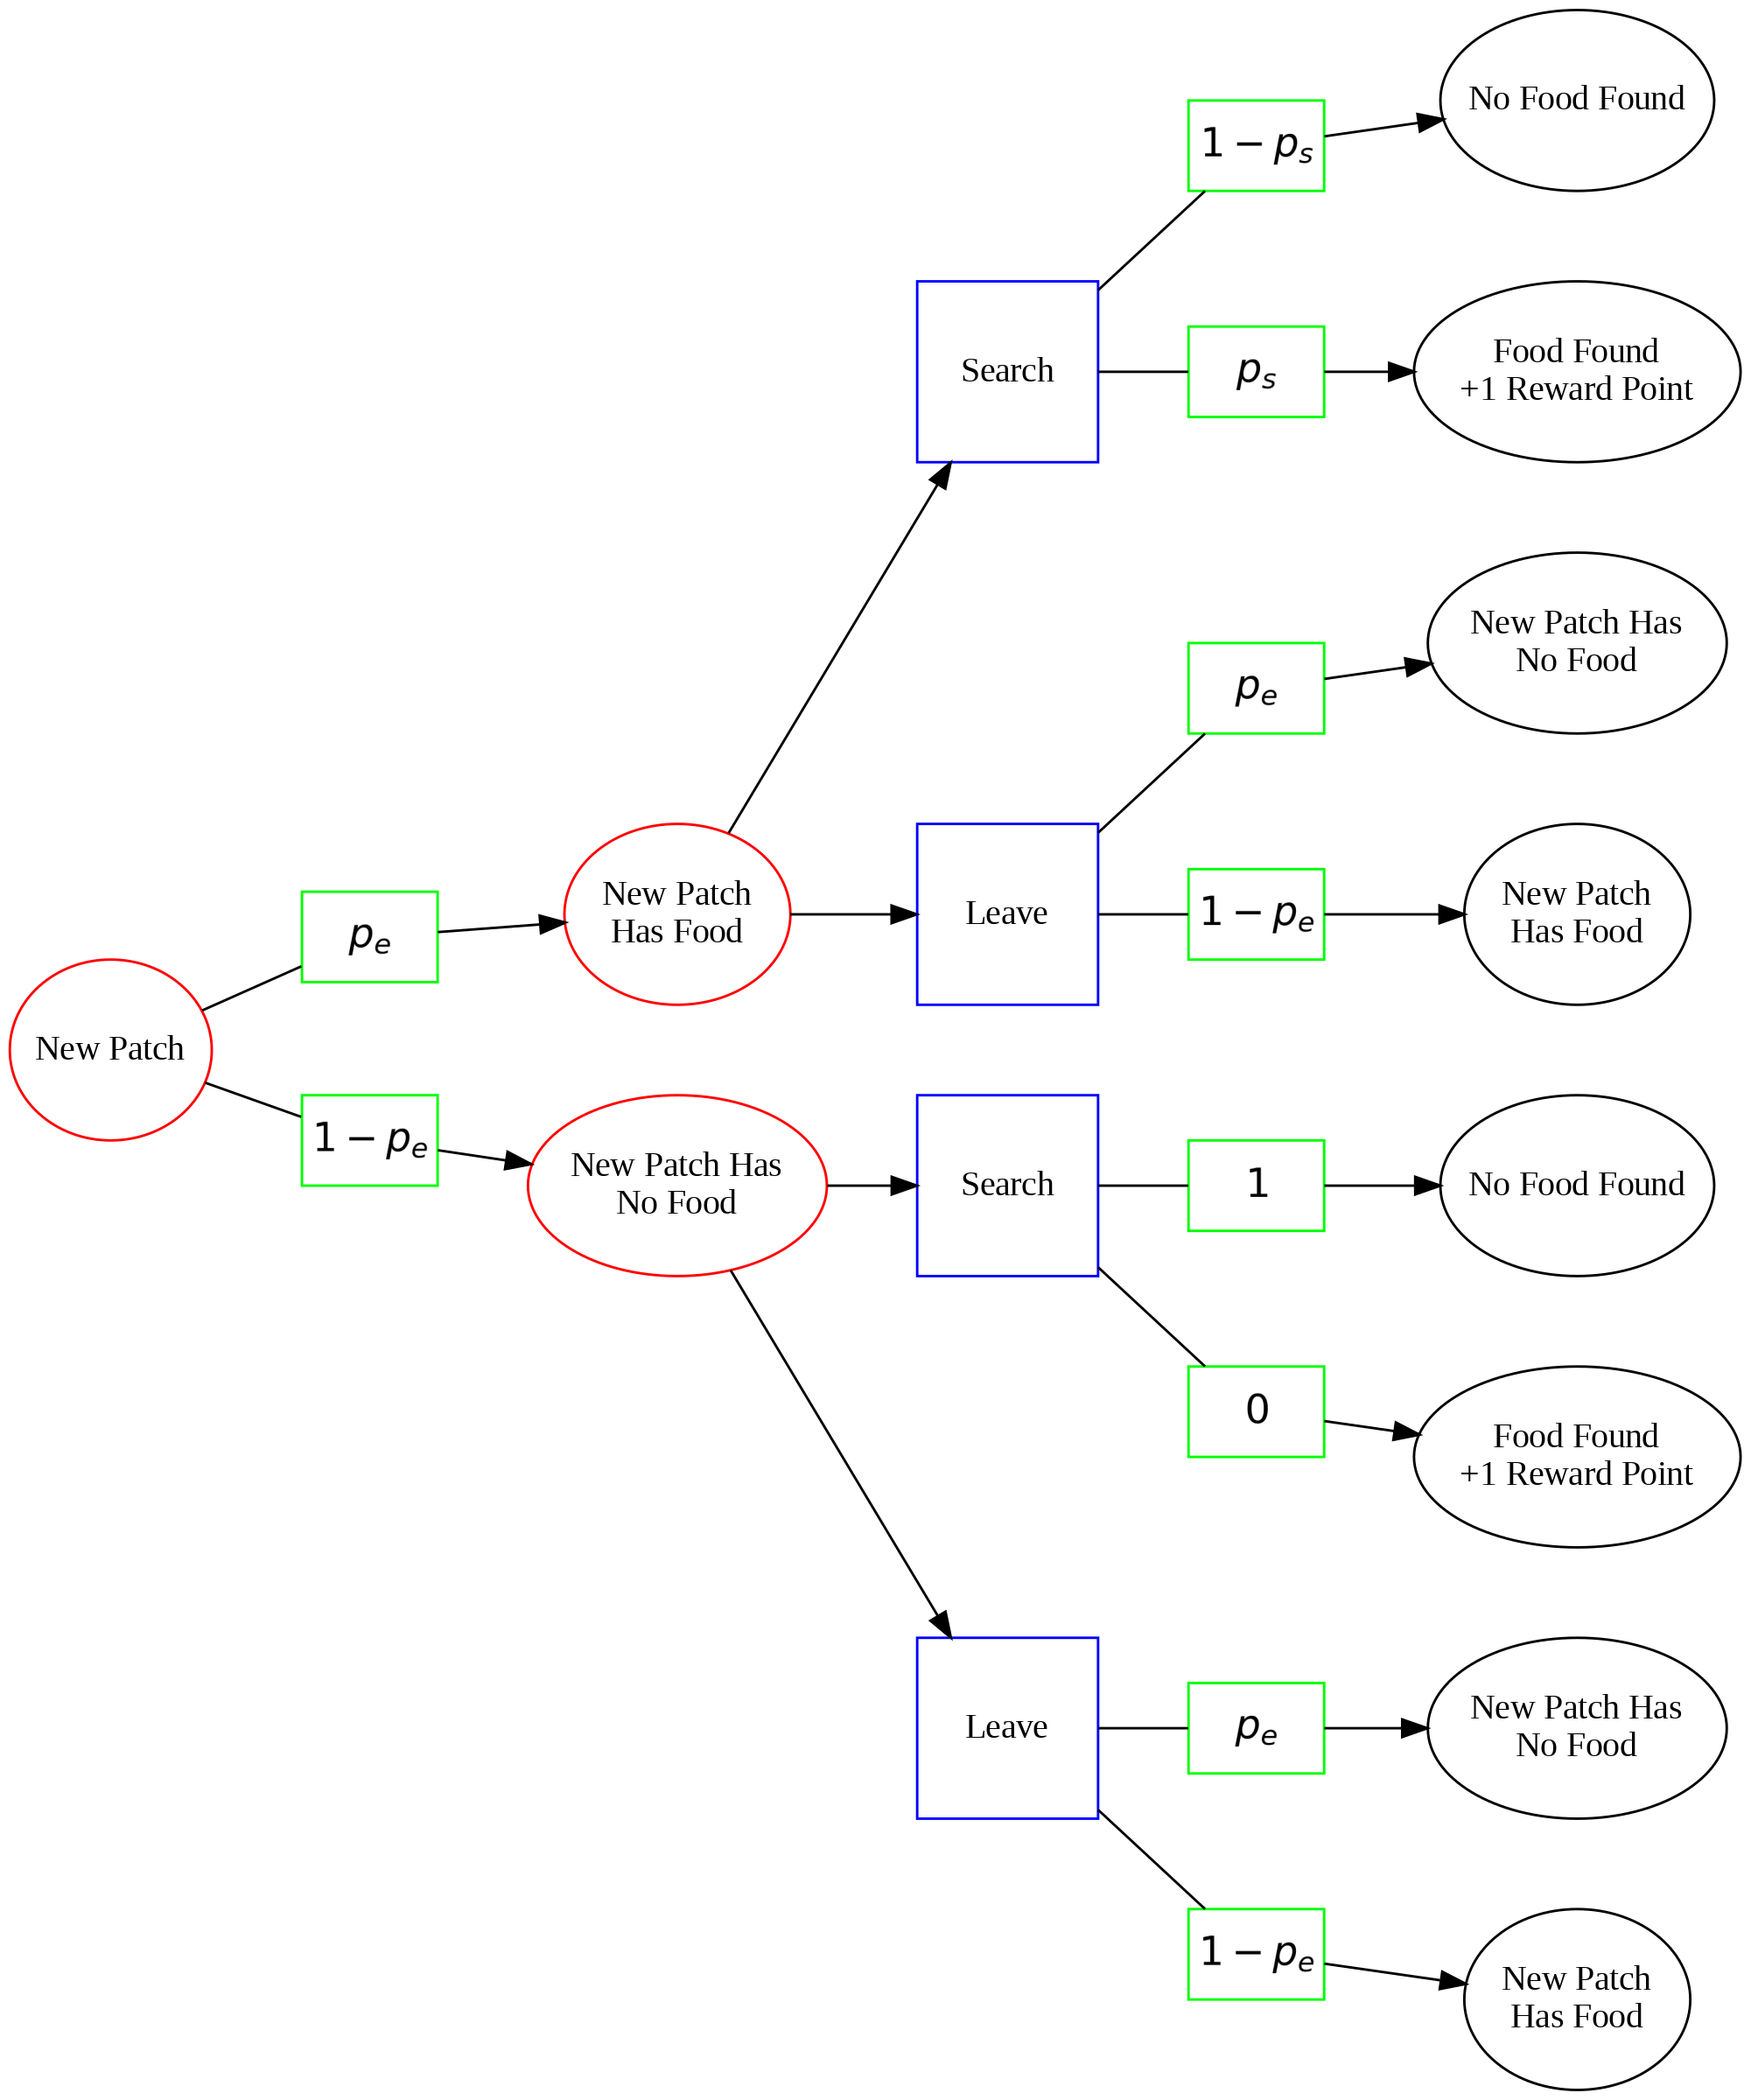

In [67]:
# @markdown **Run This Cell** to visualize the decision tree


nodes_list = [
    "New Patch", "Has Food0", "No Food0", "Didn't Find Food0", "Found the Food0",
    "No Food to Find0", "Found Impossible Food0",
    "Search (has food)0", "Leave (has food)0",
    "Search (no food)0", "Leave (no food)0",
    "Has Food1", "No Food1", "Has Food2", "No Food2"
]

edges_list = [
    ("New Patch", "Has Food0"), ("New Patch", "No Food0"),
    ("Has Food0", "Search (has food)0"), ("Has Food0", "Leave (has food)0"),
    ("No Food0", "Search (no food)0"), ("No Food0", "Leave (no food)0"),
    ("Search (has food)0", "Found the Food0"), ("Search (has food)0", "Didn't Find Food0"),
    ("Search (no food)0", "Found Impossible Food0"), ("Search (no food)0", "No Food to Find0"),
    ("Leave (has food)0", "Has Food1"), ("Leave (has food)0", "No Food1"),
    ("Leave (no food)0", "Has Food2"), ("Leave (no food)0", "No Food2"),
]

latex_edge_labels = [
    ("New Patch", "Has Food0", "p_e"),
    ("New Patch", "No Food0", "1-p_e"),
    ("Search (has food)0", "Didn't Find Food0", "1-p_s"),
    ("Search (has food)0", "Found the Food0", "p_s"),
    ("Search (no food)0", "No Food to Find0", "1"),
    ("Search (no food)0", "Found Impossible Food0", "0"),
    ("Leave (has food)0", "No Food1", "p_e"),
    ("Leave (has food)0", "Has Food1", "1-p_e"),
    ("Leave (no food)0", "No Food2", "p_e"),
    ("Leave (no food)0", "Has Food2", "1-p_e")
]

action_nodes = [
    "Search (has food)0", "Search (no food)0", "Leave (has food)0", "Leave (no food)0"
]

node_colors = {
    "New Patch": "red",
    "Has Food0": "red",
    "No Food0": "red",
}

node_labels = {
    "Has Food0": "New Patch\nHas Food",
    "No Food0": "New Patch Has\nNo Food",
    "Has Food1": "New Patch\nHas Food",
    "No Food1": "New Patch Has\nNo Food",
    "Has Food2": "New Patch\nHas Food",
    "No Food2": "New Patch Has\nNo Food",
    "Search (has food)0": "Search",
    "Leave (has food)0": "Leave",
    "Search (no food)0": "Search",
    "Leave (no food)0": "Leave",
    "Didn't Find Food0": "No Food Found",
    "No Food to Find0": "No Food Found",
    "Found the Food0": "Food Found\n+1 Reward Point",
    "Found Impossible Food0": "Food Found\n+1 Reward Point"
}


output_path = create_and_render_graph(nodes_list, edges_list, latex_edge_labels,
                                      action_nodes=action_nodes,
                                      node_colors=node_colors,
                                      node_labels=node_labels)
Image(output_path, height=600)

In this diagram rounded nodes represent states of this process, i.e. the situation the organism is in with respect to the environment. Blue squares represent actions taken by the organism, and yellow squares give the probability of transitioning from the previous state, to the next state, given the action the organism took. These transitions can also be thought of as actions taken by the environment. This the full expansion, but looking at this we can see that if the organism leaves a patch, it doesn't matter whether or not there was food there, the state of the new patch is unaffected by this so we can already simplify this slightly.

<ipython-input-66-8df1fe8638e0>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig(file_path, dpi=dpi, bbox_inches='tight', transparent=True, pad_inches=0.02)


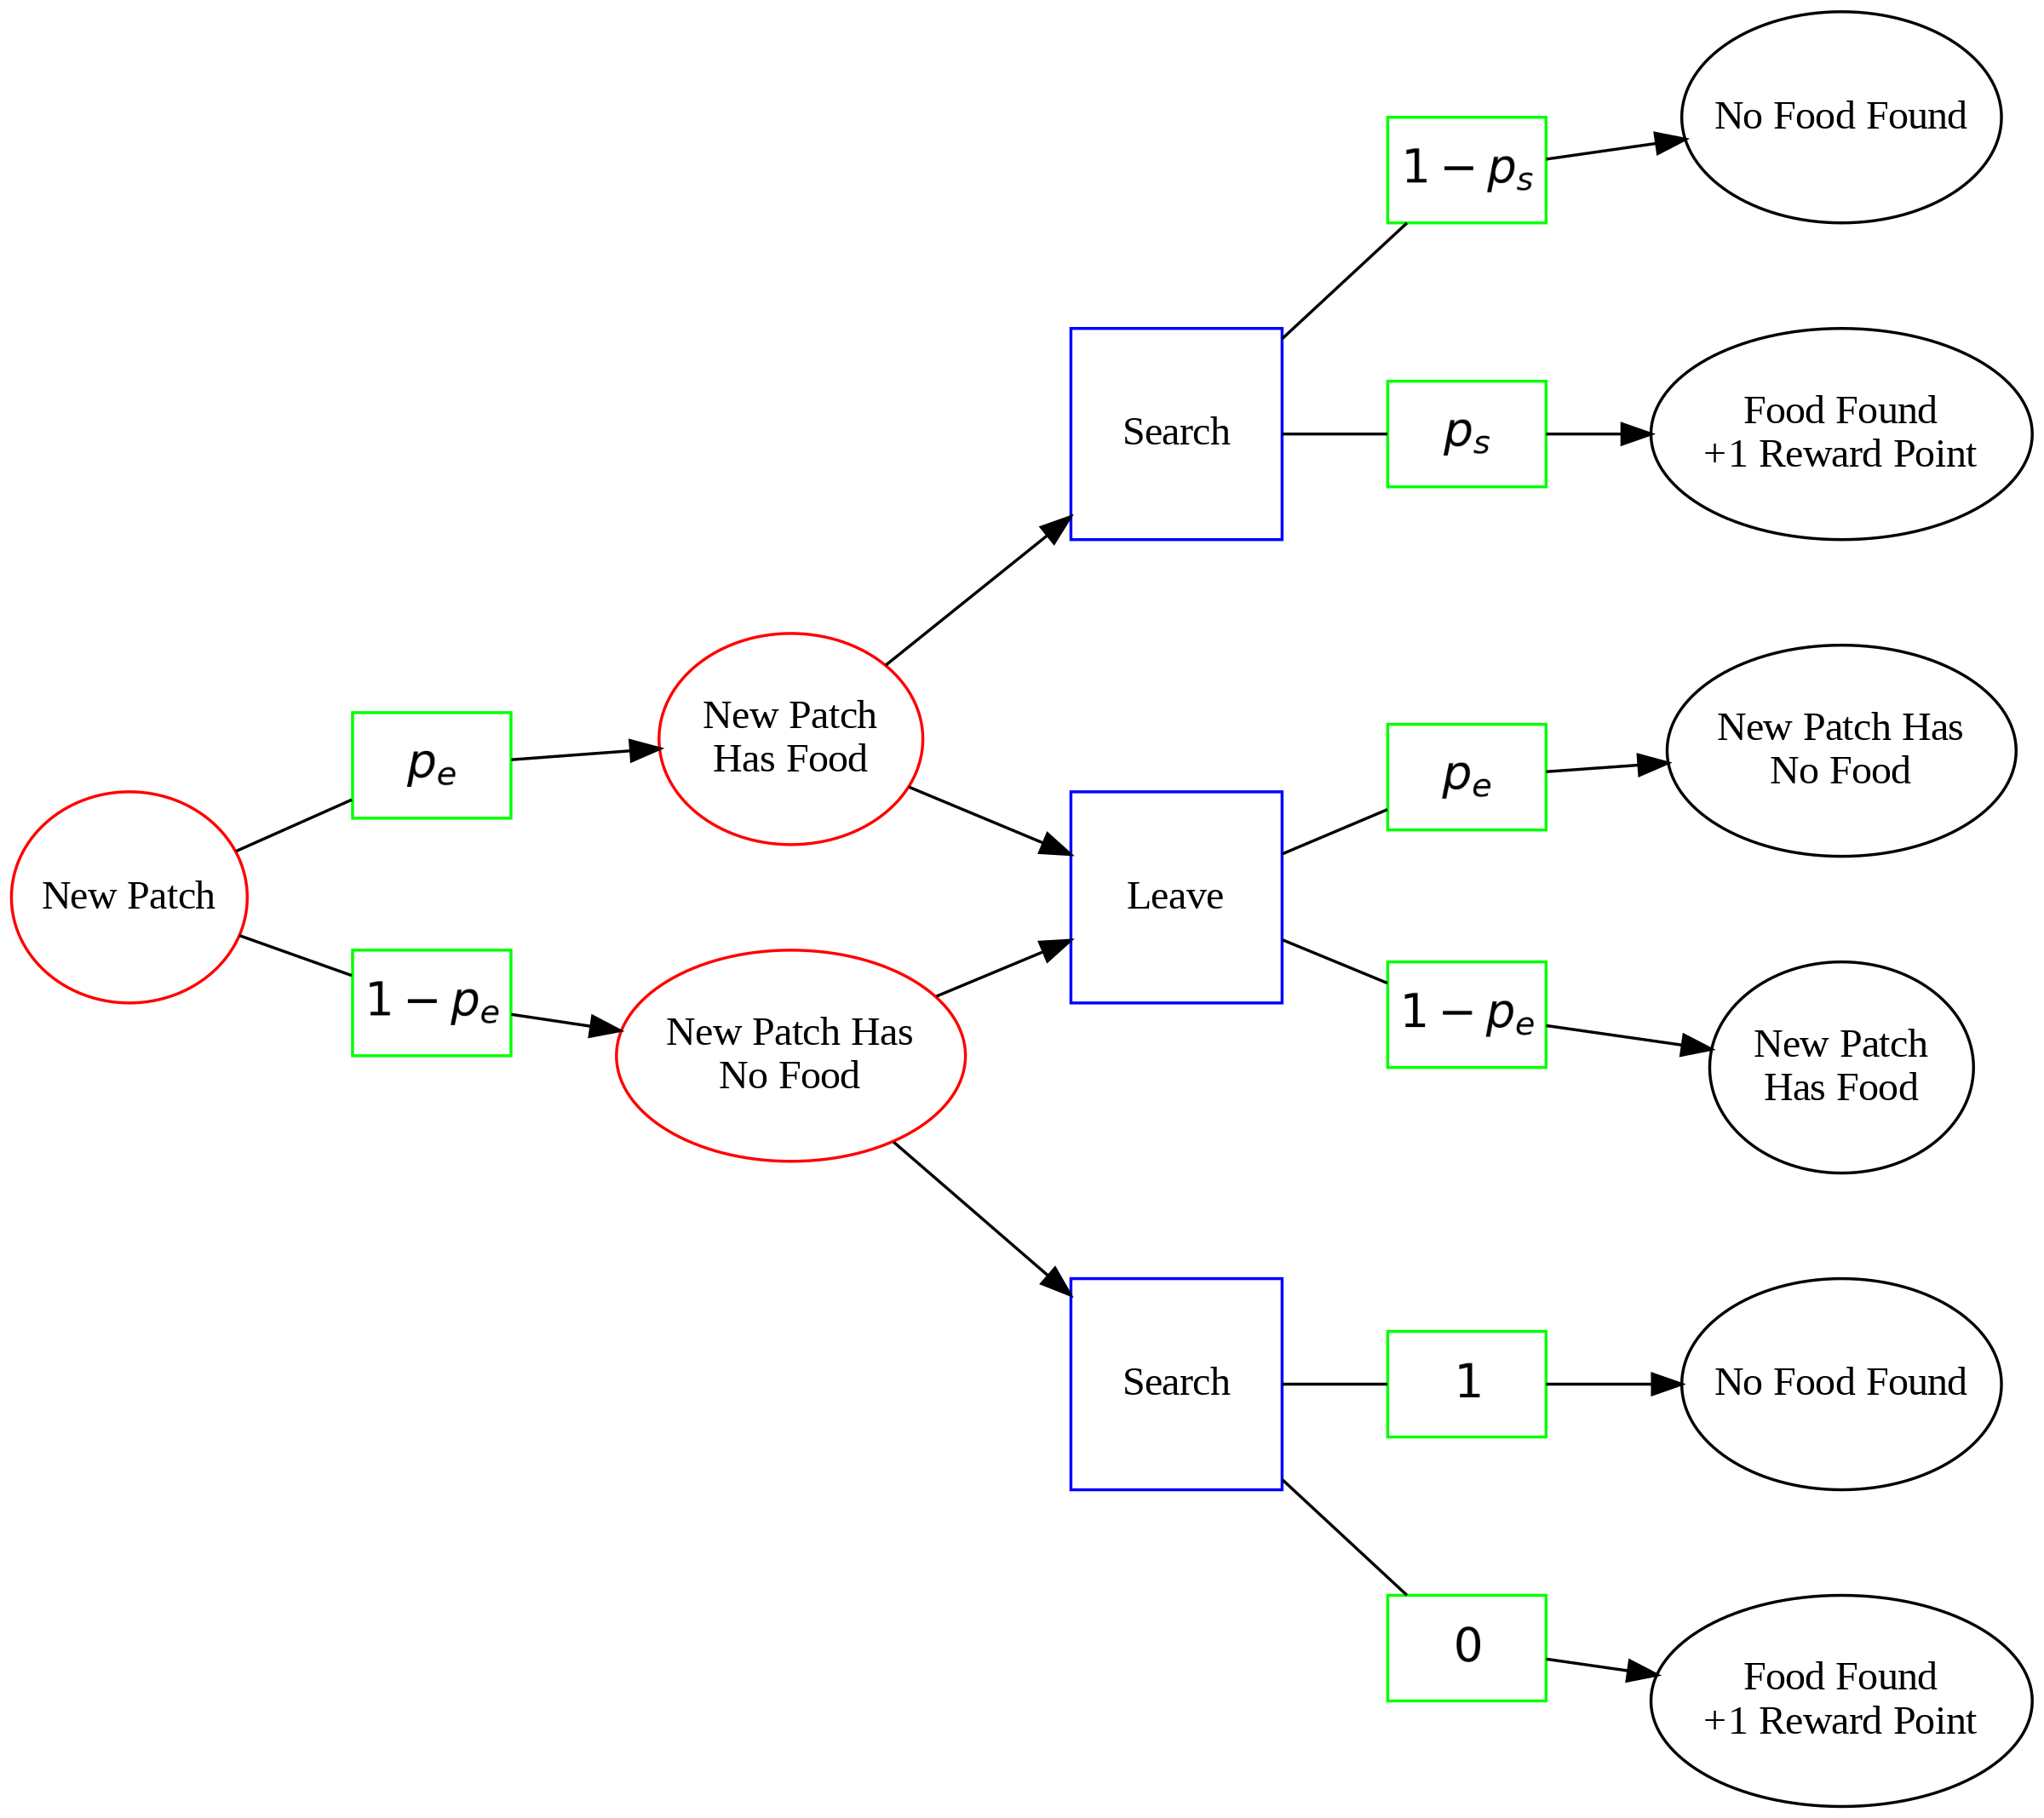

In [71]:
# @markdown **Run This Cell** to visualize the decision tree


nodes_list = [
  "New Patch", "Has Food0", "No Food0", "Didn't Find Food0", "Found the Food0",
  "No Food to Find0", "Found Impossible Food0",
  "Search (has food)0", "Leave0",
  "Search (no food)0",
  "Has Food1", "No Food1"
]

edges_list = [
  ("New Patch", "Has Food0"), ("New Patch", "No Food0"),
  ("Has Food0", "Search (has food)0"), ("Has Food0", "Leave0"),
  ("No Food0", "Search (no food)0"), ("No Food0", "Leave0"),
  ("Search (has food)0", "Found the Food0"), ("Search (has food)0", "Didn't Find Food0"),
  ("Search (no food)0", "Found Impossible Food0"), ("Search (no food)0", "No Food to Find0"),
  ("Leave0", "Has Food1"), ("Leave0", "No Food1"),
]

latex_edge_labels = [
  ("New Patch", "Has Food0", "p_e"),
  ("New Patch", "No Food0", "1-p_e"),
  ("Search (has food)0", "Didn't Find Food0", "1-p_s"),
  ("Search (has food)0", "Found the Food0", "p_s"),
  ("Search (no food)0", "No Food to Find0", "1"),
  ("Search (no food)0", "Found Impossible Food0", "0"),
  ("Leave0", "No Food1", "p_e"),
  ("Leave0", "Has Food1", "1-p_e"),
]

action_nodes = [
  "Search (has food)0", "Search (no food)0", "Leave0"
]

node_colors = {
    "New Patch": "red",
    "Has Food0": "red",
    "No Food0": "red",
}

node_labels = {
    "Has Food0": "New Patch\nHas Food",
    "No Food0": "New Patch Has\nNo Food",
    "Has Food1": "New Patch\nHas Food",
    "No Food1": "New Patch Has\nNo Food",
    "Search (has food)0": "Search",
    "Leave0": "Leave",
    "Search (no food)0": "Search",
    "Didn't Find Food0": "No Food Found",
    "No Food to Find0": "No Food Found",
    "Found the Food0": "Food Found\n+1 Reward Point",
    "Found Impossible Food0": "Food Found\n+1 Reward Point"
}


output_path = create_and_render_graph(nodes_list, edges_list, latex_edge_labels,
                                      action_nodes=action_nodes,
                                      node_colors=node_colors,
                                      node_labels=node_labels)
Image(output_path, height=600)

Similarly we can remove the zero probability event


<ipython-input-66-8df1fe8638e0>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig(file_path, dpi=dpi, bbox_inches='tight', transparent=True, pad_inches=0.02)


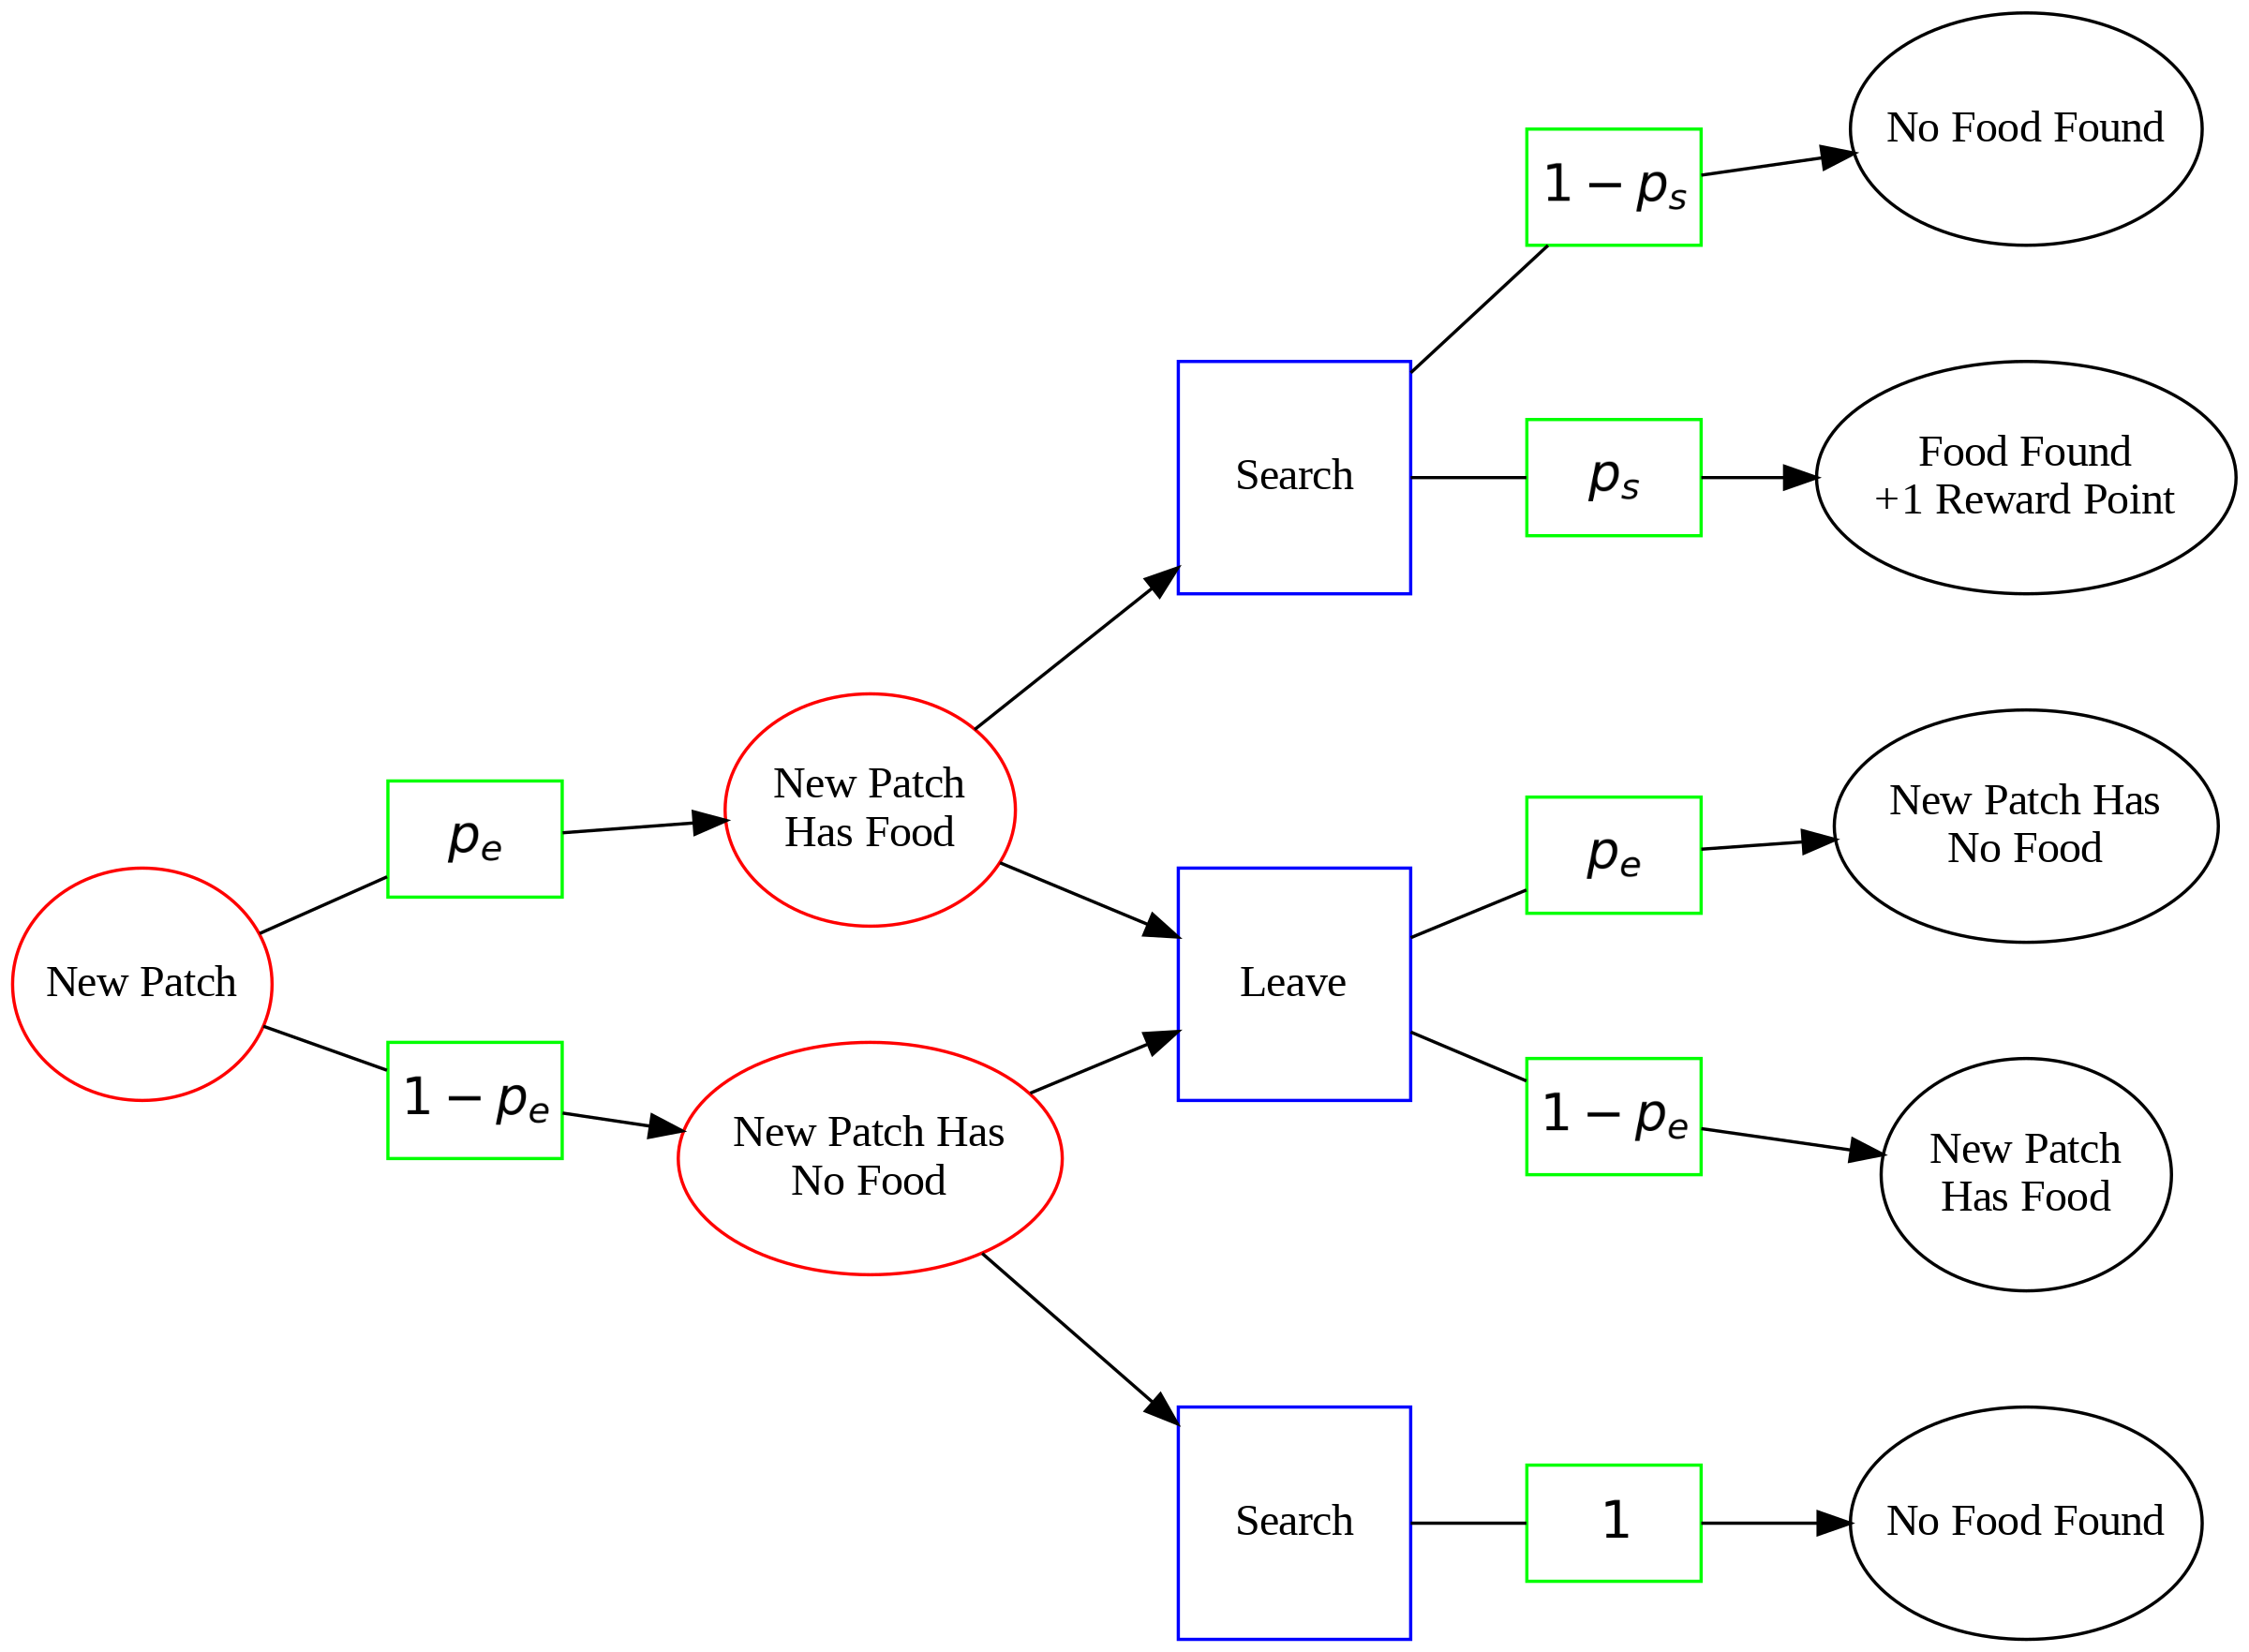

In [72]:
nodes_list = [
  "New Patch", "Has Food0", "No Food0", "Didn't Find Food0", "Found the Food0",
  "No Food to Find0",
  "Search (has food)0",
  "Search (has food)1"
  "Leave0",
  "Leave1"
  "Search (no food)0",
  "Search (no food)1",
  "Has Food1", "No Food1",
  "Search (didn't find food)0",
  "Search (found the food)0",
  "Search (no food to find)0",
  "Leave (didn't find food)0",
  "Leave (found the food)0",
  "Leave (no food to find)0",
]

edges_list = [
  ("New Patch", "Has Food0"), ("New Patch", "No Food0"),
  ("Has Food0", "Search (has food)0"), ("Has Food0", "Leave0"),
  ("No Food0", "Search (no food)0"), ("No Food0", "Leave0"),
  ("Search (has food)0", "Found the Food0"), ("Search (has food)0", "Didn't Find Food0"),
  ("Search (no food)0", "No Food to Find0"),
  ("Leave0", "Has Food1"), ("Leave0", "No Food1"),
]

latex_edge_labels = [
  ("New Patch", "Has Food0", "p_e"),
  ("New Patch", "No Food0", "1-p_e"),
  ("Search (has food)0", "Didn't Find Food0", "1-p_s"),
  ("Search (has food)0", "Found the Food0", "p_s"),
  ("Search (no food)0", "No Food to Find0", "1"),
  ("Leave0", "No Food1", "p_e"),
  ("Leave0", "Has Food1", "1-p_e"),
]

action_nodes = [
  "Search (has food)0", "Search (no food)0", "Leave0"
]

node_colors = {}

node_labels = {
    "Has Food0": "New Patch\nHas Food",
    "No Food0": "New Patch Has\nNo Food",
    "Has Food1": "New Patch\nHas Food",
    "No Food1": "New Patch Has\nNo Food",
    "Search (has food)0": "Search",
    "Leave0": "Leave",
    "Search (no food)0": "Search",
    "Didn't Find Food0": "No Food Found",
    "No Food to Find0": "No Food Found",
    "Found the Food0": "Food Found\n+1 Reward Point",
}


output_path = create_and_render_graph(nodes_list, edges_list, latex_edge_labels,
                                      action_nodes=action_nodes,
                                      node_colors=node_colors,
                                      node_labels=node_labels)
Image(output_path, height=600)

# MDP Notation
To get precise about what we are trying to optimize we first need to introduce some important notation, and formalize many of the general concepts introduced earlier in the book through our Gridworld example. If you are already farmiliar with these ideas feel free to skip this bit. Similarly if you find mathematical notation a bit overwhelming, you can also skim this section, (don't worry about understanding it all right away) and then use this as glossary as needed. A shortened version of these definitions also appear in the glossary/notation reference section found at the end of each notebook.

* $\pi_{\theta}(a|s)$: **Policy Function** - A policy is the behavioural blueprint for the organism. It's a function that takes (some representation or filtered down aspect of) the environmental state $s$ as input, and guided by its parameters $\theta$, gives the probability of taking action $a$, where $a$ is in the set $\mathcal{A}(s)$ of possible actions given state $s$. The organism can then sample an actio from this set according to these probabilities. Sometimes the explicit reference to $\theta$ is dropped when it is clear from context or does not need to be emphasized as in $\pi(a|s)$, other times the the reference to the parameters is made more explicit by writing $\pi(a | s, \theta)$. In our Gridworld example each of the organisms we defined, 'Random Valid', 'Parameterized Weights', 'Eat When Near' all had a policy function at their core.

* $s$: **A State** - The state represents a complete snapshot of what the environment looks like at a given moment. In our Gridworld example this is primarily the positions of food pieces and the organism, but also the number of rounds left in the simulation. The set of all possible states is denoted $\mathcal{S}$.

* $a$: **An Action** - The action an organism takes. Depending on how things are set up in our Gridworld example this might be represented as a direction or as a (row, columns) coordinate of the organism's new position, or as a flattened boolean index of the organism's new position. The set of all possible actions is denoted $\mathcal{A}$, and the set of possible actions in a given state as $\mathcal{A}(s)$.

* $r$ : **A Reward** - The immediate reward (feedback, score, points etc.) an organism recieves after taking an action $a$ in state $s$ and transitioning to new state $s'$. In our Gridworld example $r = 1$ if the organism eats a food piece as a result of its move and $r = 0$ otherwise.

* $\theta$: **Parameters** - The aspects of an organism's policy function that can be represented by numbers. Note that these do not describe the overall structure of the policy function, but rather determine a particular instance of the policy functions possible *given* the structure (archietecture) of a policy function. In our 'Parameterized Weights' policy from our Gridworld example, the connective weight strengths $W$ are the paramweters, i.e. $\theta = W$ in for this particular policy. For a more complicated policy with many layers of connective weights we might write $\theta = \{W_1, W_2,\dots, W_N \}$. We use $\theta$ as a generic term so that we can make general statements about parameterized policies without having to worry about the particular archiectecure or functional form of the policy.   

Given the stochastic nature of the environment (and often the policy as well), at any given time $t$ over the course of a simulation run, each of states, actions and rewards can be thought of as random variables specifically:

* $S_t$: **State at Time $t$** - A random variable that denotes the state of the environment at a specific time $t$. For example, $S_t = s$ means that at time $t$, in a particular simulation run, the environment was in state $s$, or in other words that $s$ is the realization of the random variable $S_t$.

* $A_t$: **Action at Time $t$** - A random variable denoting the action taken by the organism at time $t$. $A_t = a$ indicates that the action $a$ is taken at time $t$, or that $a$ is the realization of the random variable $A_t$ in a particular simulation run.

* $R_t$: **Reward at Time $t$** - A random variable indicating the immediate reward received by the organism at time $t$. $R_t = r$ indicates that the reward $r$ is obtained at time $t$, or in that $r$ is the realization of the random variable $R_t$ in a particular simulation run.

* $T$: **Total Simulation Time** - The total number of time steps in a given simulation. There are cases where having an infinite time horizon, $T=\infty$, is a mathematical convenience, but since our focus is on evolved, living and learning systems, and few things live forever, we will typically work with a finite time horizons.

* $t$: **Time-Step Index** - We typically subscript with $t$ to denote the value of a state, reward, action, etc. at a given specific time $t$.

We can then think of simulation run as sequence of random variables:
$$S_0, A_0, R_1, S_1, A_1, R_2, S_2, A_2, R_3, \dots, S_{T-1}, A_{T-1}, R_{T}, {S_T}$$

The dynamics, or equations of motion, that generate this sequence of random variables are primarily encapsulated in a *transition function*, together with an *initial state distribution*, both defined as follows.

* $p(s', r | s, a)$: **Transition Function** - Sometimes called the *State Transition Function*, or the *Transition Kernel* (kernel is more common when dealing with continuous state spaces) this function give the probability of transitioning from state $s$ to $s'$ and recieving reward $r$ from time-step $t$ to $t+1$, given that action $a$ is taken at time $t$. In terms of our previous notation this is defined as:
$$ p(s', r | s, a) := \Pr \{S_{t+1} = s' , R_{t+1} = r | S_t = s, A_t = a \}$$  

* $p_0(s)$: **Initial State Distribution** - This is the probability distribution (density function) over the set of possible states, \mathcal{S}, so $p_0(s) := \Pr \{S_0 = s\}$. Sometimes we write $S_0 \sim p_0$, which is read as 'The random variable $S_0$ is distributed according to the probability density function $p_0$'.

This random variable notation also allows us to make uur definition of a policy function more precise: $$\pi_{\theta}(a | s) := \Pr \{A_{t} = a | S_t = s\}.$$

Then, if a policy is fixed it can simply be folded into the dynamics of the environment, creating what is refered to as the *policy-induced dynamics*.

* $p_\pi(s', r | s)$: **Policy-Induced Dynamics** - This is also called the 'dynamics under policy $\pi$' and is defined as:
$$p_\pi(s', r | s):= \Pr \{S_{t+1} = s' , R_{t+1} = r | S_t = s, \pi \} = \sum_{a\in\mathcal{A}(s)} \pi_\theta (a | s) \ p(s', r | s, a).$$
Sometimes the depedence on a specific policy, $\pi$, is taken as implicit and we simply write $p(s', r | s)$.

The takeaway here is that for a fixed $\pi$ and a given transition function $p$ (and initial state distribution $p_0$) the stochastic dynamics of the system are completely determined.

With all that defined we can start to formally describe how rewards should be added up over time to define our goals. We just need to introduce the idea of a *Return* and a *Value* function.

* $G_t$: **Return following time $t$** - Sometimes called the reward to go, or simply the return, this a random variable that indicates the total reward yet to be realized after time $t$, i.e. $G_t := \sum_{k=t+1}^T R_k$.

* $v_{\pi}(s,t)$: **Value Function** - A function giving the *expected* return conditional on being in state $s$ at time $t$ and following a given policy $\pi$, specifically:
$$v_{\pi}(s,t) := \mathbb{E}_\pi \left[G_t | S_t = s \right].$$
In a slight stretch of notation $t$ can be treated as part of $s$ and we can write $v_{\pi}(s)$. The dependence on a specific policy is sometimes treated as implicit and we write $v(s)$ or $v(s,t)$.

In this context then our goal is to maximize the *Expectation* of a simulation run, or equivalently the average value from playing through many simulations (in the limit as many --> $\infty$). We call this formalization of our goal objective function and define our particular objective function in this context as

* $J(\theta)$: **Objective Function** - The function that we are trying to maximize, emphasizing the dependence on the parameters, $\theta$.

The objective function is in some ways the most subjective thing in this whole set up. It's what defines the "problem to be solved". In our particular case we we are going to use the following as our objective.

$$J(\theta):= \mathbb{E}\left[ v_{\pi_\theta}(S_0) \right] = \sum_{s \in \mathcal{S}} p_0(s) \cdot v_{\pi_{\theta}}(s)$$

Then the formalization of our problem is choosing parameters $\theta$ such that $J(\theta)$ is as high as possible. In general this goal is written as:
$$ \max_{\theta} J(\theta),$$

and in our particular case of maximizing the expected value, given a finite and discrete state space, our goal is written as:

$$ \max_\theta\sum_{s \in \mathcal{S}} p_0(s) \cdot v_{\pi_{\theta}}(s)$$

# 1.3.1.1: A Bite-Sized Evolution Example

We're going to explore the fundamentals of evolution using the following simple scenario. Drawing inspiration from the sand-striker worm (Eunice aphroditois), imagine an organism that lurks in its burrow, with just its chemosensory antennae sticking out. Whenever food that 'smells good' (as determined by its antennae receptors) passes by, the worm lunges from its lair to snatch the morsel, incapacitate it if need be, and drag it back home for a feast. Yum! We model this organism with a simplified 'genome'—an array of bits where each bit codes for the presence (1) or absence (0) of a distinct chemosensory receptor on the worm's antennae.

The organism's life centers around one core problem: to 'strike' or 'not strike'. A successful strike at edible food yields a reward, $r$. While the immediate benefits of this come from fats, proteins, and calories, and the impact of these resources on survival and reproduction fluctuates based on the worm's condition, we simplify by saying each successful capture increases the number of viable gametes by $r$, thereby affecting the chances of the organism's offspring being in the next generation. Conversely, a missed strike has a cost, $c$. While these immediate costs manifest as increased predation risk or lost opportunity, which may have complex impacts on survival and reproduction depending on the worm's condition, we again simplify this cost as a constant gamete decrement by $c$.

The environment our organism finds itself in, in this first minimal example, consists of a series of encounters with several different kinds of food and non-food items. Each kind of item is tagged with distinct chemical markers, akin to different 'scents' or 'flavors'. Note that these markers will sometimes partially (but never totally) overlap between items regardless of food / non-food categorization, depending on the particular details of the environment. This creates potential for misjudgment. Our organism's chemosensory antennae, coded by its genome, are sensitive to these markers. In each of these encounters, the organism faces its core 'strike' or 'not strike' problem, which it 'solves' with the following decision rule: the worm strikes only if ***all*** of its receptors pick up a marker and refrains from striking if ***any*** of its receptors are left unactivated. (When the organism has no receptors technically all of its non-existent receptors are activated and so it strikes in all situations.) In the simulation below see if you can find the optimal 'genome' for an organism. To get started, you can observe the 'markers' on the different food and non-food items.

In [6]:
# @title Twiddle the Genes
# @markdown Run this cell to tweak the genome. Click the compute button to see how the organism fares over 100 random trials
gt = GenomeTwiddle(show_env=True, num_receptors=4)
gt.display()

So already in this very simple example some interesting things are happening. In our example, by construction, each location on the genome represents a 'gene' for a specific receptor with two possible alleles: the presence or absence of the corresponding chemosensory receptor on an antenna. However, we might also zoom out our analysis and look at traits at the behavioural level. For example, if we say that 'Striking at Food Item 2' (with markers '1011') is a trait, then we find that any of the genes for receptor 1, 3, or 4 might equally be considered a 'Gene for Striking at Food Item 2'. In a different environment, where the markers for food and non-food items vary—for instance, if 'Food Item 2' had markers '1000 instead—then only the gene for receptor 1 might be considered the 'Gene for Striking at Food Item 2'. This hints at the potential complexity of the mapping from gene to behaviour (through ontogeny and mechanisms) and also emphasizes the strong context-dependence of this mapping, i.e. its sensitivity to the specifics of the environment.

Despite this complexity, as we'll soon see, the evolutionary process still manages to shape and select for complex traits. When you were twiddling the genes in the exercise above, you had the benefit of knowing what the markers were for the food and non-food items, the costs and rewards of different outcomes, the relative frequencies of food versus non-food items appearing, and the feedback about true and false negatives and positives. The evolutionary process is effectively blind to all of this. The problem that evolution faces is more like the following exercise, where the only feedback is a 'fitness score,' with no awareness of how that score came about. (Note that the individual organism may be aware of the differences between true and false positives, and maybe even between true and false negatives, but the evolutionary process itself is not.)

In [7]:
# @title Twiddle the Genes in Ignorance
# @markdown Run this cell to tweak the genome. Click the compute button to see how the organism fares over 100 random trials
gt = GenomeTwiddle(show_env=False, scramble_key=False, mimics=True)
gt.display()

So, with just four receptors, this problem isn't so difficult. It's relatively easy to test various combinations and observe what works well and what doesn't. With the highly stochastic feedback it's hard to know if we have the exact best receptor configuration, but we can at least find a good configuration. What about when there are more receptors?

In [ ]:
# @title An Overwhelming Number of Genes and Receptors
# @markdown Run this cell to tweak the genome. Click the compute button to see how the organism fares over 100 random trials
gt = GenomeTwiddle(show_env=False, num_receptors=16, scramble_key=True,
                   num_food_types=100, num_non_food_types=400, mimics=True)
gt.display()

The curse of dimensionality strikes again!

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M1")

# 1.3.1.2: Evolution Acts on Populations

One of the ways that evolution is able to search high-dimensional parameters spaces (big genomes) despite the curse of dimensionality is because it operates in a massively parallel manner. Many variants are evaluated in parallel within each generation, potentially as many as there are individuals in a population.

In a very [coarse first approximation](# "This is a good first approximation but completely fails to address many critical aspects of evolution, in particular the emergence of new genetic loci."), evolution can be thought of as changes in allele frequencies within a population. In this simplified framing evolution can be seen as the aggregate effects at the population level of selection acting on individuals. Populations evolve; individuals are selected.

To see how evolution can search a large and opaque genotype space for a good solution to this 'strike' or 'no strike' problem, we will simulate evolution in a population of organisms. We'll apply the 'environmental seive' by having those individuals with the highest score in the 'strike' or 'no-strike' game be the ones most likely to have their offspring in the subsequent generation. In this first simplified simulation, we will work with asexual haploid organisms. Note that sex—and other forms of gene transfer—along with multiple chromosomes are the general rule in life. In the next sequences, we will explore how sex (and recombination enabled by diploidy) can radically amplify the effectiveness of evolution's pure brute-force parallelism.

Run the cell below see brute force parallelism of evolution find good a solution for a 20-receptor/marker organism/environment system.

In [ ]:
fitness_hist = evolutionary_simulation(
    num_receptors=20, slct_temp=5.0, random_init=False,
    num_generations=100, has_mutation=False, cost=1, reward=1,
    population_size=100, hard_mode=True, stop_at_converged=True,
    num_food_items =2, num_non_food_items=20, seed=12)

So the simulation above worked well... perhaps. With 20 receptors, there are $2^{20} \approx  1 \text{million}$ different types to evaluate. However, our population only consisted of one hundred individuals. This process quickly selected the best variant in the existing population. But, what if there are better variants that were not in this initial population? Let's take a look at the selected variant and think about whether or not a better variant is possible.


In [ ]:
# What receptors did the dominant variant have?
binary_str = bin(66520)[2:]
padded_binary_str = binary_str.zfill(20)
print(padded_binary_str)

Comparing this receptor pattern to the food and non-food markers used in the simulation above we see that this pattern will cause the organism to always strike at one of the food items (the one with marker 10110100111111111111) but not the other, and to strike at just two of the ten possible non-food items. So it will avoid most false positive strikes, but miss out on half of the food opportunities. Looking at the food and non-food markers in the simulation above we can see that an organism with receptors 00000000001111111111 will have perfect discrimination between food and non-food items. However this 'best' variant was not in the initial population and a purely selective process will never generate novel better variants. We need a way of introducing variation into the population. We need mutation.

In [ ]:
fitness_hist = evolutionary_simulation(
    num_receptors=20, slct_temp=5.0, random_init=False,
    num_generations=200, has_mutation=True, mutation_rate=0.02,
    population_size=100, hard_mode=True, n_trials=100, cost=1, reward=1,
    num_food_items =2, num_non_food_items=20, seed=12, stop_at_converged=False)

In [ ]:
# This was the receptor pattern of the dominant variant
binary_str = bin(1023)[2:]
padded_binary_str = binary_str.zfill(20)
print(padded_binary_str)

Mutation effectively introduced variation, allowing the parameter space to be searched more thoroughly. The mean population fitness stabilized around 42.7 after this simulation, compared to approximately 22.4 in the previous simulation without mutation. But can we do better? Unfortunately, we can't assume that just because this is the output of an evolutionary process, we have reached some kind of globally optimal solution. (Although in this case by inspecting the problem we can conclude that our evolutionary process with mutation did indeed find the best solution in this instance). One important reason for this is because evolution is effectively a hill climbing algorithm. Mutations make small steps in the genotype/parameter space, and if these mutations prove beneficial (which they often don't), they are more likely to be retained in subsequent generations (this is selection). These beneficial mutations then become the basis for further exploration of the parameters space through additional mutations. But there is always the possibility that there is some really great solution that was not reachable by an 'adaptive path' of mutations.

Consider a scenario where two peaks represent local optima in the fitness landscape. These peaks are separated by a 'maladaptive valley,' a region of lower fitness. An evolving population that starts near one of these peaks would likely climb toward that local optimum due to natural selection favoring incremental improvements. However, reaching the higher peak on the other side of the valley would require a sequence of mutations that initially decrease fitness before eventually leading to a much higher fitness level. In such cases, natural selection would typically weed out these 'stepping-stone' mutations before they could lead to the higher peak, causing the population to get stuck at the lower local optimum. We can see just such an example of this scenario play out the simulation below.

In [ ]:
fitness_hist = evolutionary_simulation(
    num_receptors=3, slct_temp=5.0, random_init=False,
    num_generations=1000, has_mutation=True, mutation_rate=0.0001,
    population_size=100, seed=12,
    cost=1.0, reward=2.0, food_freq=0.5,
    food_markers=np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0]]),
    non_food_markers=np.array([[1, 1, 0], [1, 0, 1], [0, 1, 1]]),
    initial_variant=np.array([0, 0, 0], dtype=np.bool_), stop_at_converged=False)

In this example, the population starts out completely dominated by the all receptors '111' (aka variant 7). None of the food items ('001', '010', '100') trigger a strike for this variant, nor do any of the non-food items ('011', '101', '110'). As a result, this variant never strikes and neither gains nor loses fitness from the strike/no-strike aspect of their life. Occasionally, mutation introduces a new variant, but over the course of the thousand generations in the simulation, all of these are 1-bit mutants. While these mutants still don't strike at any of the food items, they do strike at one of the non-food items, incurring a cost of $c$ in one-sixth (half of the scenarios are non-food items and one-third of those are the specific non-food item that a particular mutant will strike). Because these mutants have lower fitness than the dominant type they are swiftly removed from the population by selection.

Yet, there is a better solution. In this example, the reward for successful strikes is $r=2$, which is greater than the cost $c=1$ of striking non-food items. Given that food and non-food items are equally likely to be encountered, striking at everything results in positive expected fitness increment. This makes it a better strategy than striking at nothing, which has an expected reward of zero. However, in the simulation above, our process couldn't reach this superior solution. This is because these local optima in the fitness landscape were separated by a so-called 'fitness valley,' and there was no 'adaptive path' bridging them.

In [ ]:
# @markdown Run this cell to visualize the 3 marker/receptor genotype space and the 'fitness valley' of this particular example.
def one_bit_difference(node1, node2):
    """Check if two nodes have a 1-bit difference."""
    return sum(a != b for a, b in zip(node1, node2)) == 1

# Create a new graph
G = pgv.AGraph(strict=True)

# Add nodes for food types and non-food types
nodes = [[0, 0, 0],
         [1, 0, 0], [0, 1, 0], [0, 0, 1],
         [1, 1, 0], [1, 0, 1], [0, 1, 1],
         [1, 1, 1]]


positions = {
    str([0, 0, 0]): "0,1",
    str([1, 0, 0]): "2,2",
    str([0, 1, 0]): "2,1",
    str([0, 0, 1]): "2,0",
    str([1, 1, 0]): "4,2",
    str([1, 0, 1]): "4,1",
    str([0, 1, 1]): "4,0",
    str([1, 1, 1]): "6,1"
    }


for node in nodes:
    if node in [[1, 0, 0], [0, 1, 0], [0, 0, 1]]:
        G.add_node(str(node), label=str(node), color="red", pos=positions[str(node)], pin=True)
    elif node in [[1, 1, 0], [1, 0, 1], [0, 1, 1]]:
        G.add_node(str(node), label=str(node), color="red", pos=positions[str(node)], pin=True)
    else:
        G.add_node(str(node), label=str(node), color="blue", pos=positions[str(node)], pin=True)

G.node_attr['width'] = '1'
G.node_attr['height'] = '1'

# Add edges for nodes with 1-bit difference
for i in range(len(nodes)):
    for j in range(i, len(nodes)):
        if one_bit_difference(nodes[i], nodes[j]):
            G.add_edge(str(nodes[i]), str(nodes[j]))

# Save the graph to a PNG file
filename = "evolution_graph.png"
G.layout(prog='neato')
G.draw(filename, format='png')

# Display the PNG file using Image
Image(filename)

The blue nodes in the genotype space represent local optima of the fitness function, while the red nodes depict the fitness valley that separates them.

**Exercise**

The expected fitness value of genotype '000', which strikes at everything, is calculated as:
$$\text{# trials} \cdot (\text{food frequency} \cdot r + (1 - \text{food frequency}) \cdot c) = 100 \cdot (0.5 \cdot 2 - 0.5 \cdot 1) = 50$$
Similarly the expected fitness value of genotype '111', which strikes at nothigh is calculated as 0.

1. Calculate the expected fitness for the 1-bit genotypes ('100', '010', '001') situated in the 'fitness valley'. These all have the same expected fitness, since they strike at one of the three food items, and two of the three non-food items. Recall each food item and non-food item is equally likely to be the item present in a given trial.
  
  Answer: $100 \cdot(\frac{1}{6} \cdot 2 - \frac{2}{6} \cdot 1) = 0$

2. Calculate the expected fitness for the 2-bit genotypes ('110', '101', '011') located in the 'fitness valley'. Again, they all share the same expected fitness, striking at none of the three food items, but one of the three non-food item. Again, each food item and non-food item having an equal likelihood of being the item present in a given trial.

  Answer: $100 \cdot ( 0 + \frac{-1}{6}) \approx -16.67$)

One way to traverse such fitness valleys is by increasing the mutation rate, enabling the population to explore more widely. In the simulation above, with the mutation rate set at $\mu=0.0001$, mutants differing from the dominant type by more than one bit were extremely rare (i.e., they didn't appear during our 1,000-generation simulation). However, when we increase the mutation rate, in the simulation below we see that crossing this 'valley' becomes much more feasible.

In [ ]:
fitness_hist = evolutionary_simulation(
    num_receptors=3, slct_temp=5.0, random_init=False,
    num_generations=400, has_mutation=True, mutation_rate=0.01,
    population_size=100, num_food_items =1, num_non_food_items=2, seed=12,
    cost=1.0, reward=2.0, food_freq=0.5,
    food_markers=np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0]]),
    non_food_markers=np.array([[1, 1, 0], [1, 0, 1], [0, 1, 1]]),
    initial_variant=np.array([1, 1, 1], dtype=np.bool_), stop_at_converged=False)

Cranking up the mutation worked, in this case. Can mutation be too high though? Let's increase the mutation rate in the next simulation to $\mu=0.1$ and see what happens.

In [ ]:
fitness_hist = evolutionary_simulation(
    num_receptors=3, slct_temp=5.0, random_init=False,
    num_generations=400, has_mutation=True, mutation_rate=0.1,
    population_size=100, num_food_items =1, num_non_food_items=2, seed=12,
    cost=1.0, reward=2.0, food_freq=0.5,
    food_markers=np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0]]),
    non_food_markers=np.array([[1, 1, 0], [1, 0, 1], [0, 1, 1]]),
    initial_variant=np.array([1, 1, 1], dtype=np.bool_), stop_at_converged=False)

With this higher mutation rate we observe that even though the optimal variant is identified, the high mutation rate results in a decrease in overall population fitness. In this simulation the mean population fitness is approximately 35.9, significantly lower than the expected fitness score of 50 for the best variant. This hints at a fundamental trade-off between exploration (seeking new solutions) and exploitation (utilizing current best solutions). Low mutation rates can trap the evolutionary process in suboptimal local fitness peaks, hindering the discovery of superior solutions. However, a high mutation rate reduces overall fitness, since mutations typically deviate from an already effective genotype. With this in mind, let's look a little more formally at how evolution can (and can't) be thought of as fitness optimization process.

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M2")

# 1.2.3.3: How Evolution 'Optimizes' Fitness  


Because of selection, the population's dominant genotype is more likely to shift toward regions of higher fitness. Over time, this leads to populations typically being found in these high fitness regions, which explains the highly adapted traits observed in nature. In this sense both real-world evolutionary processes and the simulated versions we've explored can be thought of optimization algorithms finding good parameters for a fitness function. But there are some key differences. One such key difference is that evolution has no termination condition. Evolution doesn't stop when a 'good enough' or 'best' solution is reached because the process is blind to the overall structure of the problem being solved. So, even after stumbling upon a 'good' solution, mutations continue, and they mostly end up being counterproductive. When a complicated and efficient system is working well, most changes will make things worse!

This is somewhat at odds with our observations last chapter where normative evolutionary thinking was used to explain the observation of many adaptive behaviours and traits out in the natural world. How can an ongoing restless process like evolution result in highly adapted organism?

The answer lies in the dynamic properties of evolutionary processes. With enough selection pressure, evolution exhibits 'sticky attractors' within the landscape of genetic possibilities. These are states that, once attained, tend to be stable over long periods, even amidst ongoing mutations. The 'stickiness' of these attractors means that, despite continuous evolution, populations tend to remain within these high-fitness states.

This discussion above, while illustrative, is somewhat abstract. To make this argument more concrete we will need to focus on a specific well defined system. Let's start.

Consider a genotype space denoted $G$, consisting of sequences of bits of length $n$. There's a fitness function $f(g): G \rightarrow \mathbb{R}$ that maps each genotype $g$ in $G$ to a real number representing its fitness. For the sake of simplicity, we'll assume that fitness depends solely on an individual's genotype, not on the genotypes of others in the population, or the genotypes present in other evolving population, and that this function (which represents the environment) remains constant throughout the process. We will address changing fitness functions and fitness function that depend on the genotype of other individuals later in this chapter.

For analytic simplicity, let's further assume that selection pressure is strong and mutation rates are low. This leads to two significant effects: the population is generally dominated by a single variant, and given the rarity of mutations, we need only consider whether a new mutant can supplant the current dominant variant to understand the long-term dynamics of this evolutionary process. This method of analysis, sometimes known as 'mutant invasion analysis', is a cornerstone of quantitative genetics and evolutionary game theory [further reading].

By setting the mutation rate low in our simulation we can see these two effects in action.

In [ ]:
# Simulation with low mutation rate and strong selection
fitness_hist = evolutionary_simulation(
    num_receptors=3, slct_temp=5.0, random_init=False,
    num_generations=600, has_mutation=True, mutation_rate=0.0001,
    population_size=100, num_food_items =1, num_non_food_items=2, seed=12,
    cost=1.0, reward=1.0, food_freq=0.5,
    food_markers=np.array([[1, 1, 1]]),
    non_food_markers=np.array([[1, 1, 0], [1, 0, 1], [0, 1, 1]]),
    initial_variant=np.array([0, 0, 0], dtype=np.bool_), stop_at_converged=False)

Because we assume mutations are rare and selection is strong we can focus our analysis on the probability of our evolutionary process transitioning from a population with dominant variant $g$ to one with dominant variant $g'$. This transition probability is the product of two factors:
1. The probability of a mutant type $g'$ arising in a population where $g$ is dominant.
2. The fixation probability, $\phi(g, g')$, which is the probability of $g'$ becoming the dominant variant once introduced by mutation.

First let's consider the probability of a mutant arising. Given a per-bit mutation rate, $\mu$, a genome length of $n$ bits, and a population size $N$, we can calculate:
* Probability of no mutants showing in a generation: $$(1-\mu)^{n \cdot N}$$
* Probability of exactly one 1-bit mutant in a generation: $$N \cdot [n \cdot \mu \cdot (1-\mu)^{n-1}] \cdot (1-\mu)^{n \cdot(N-1)}$$
* Probability of more than one mutant, or a mutant with a multi-bit mutation, or some combination of these events: $$1 - N \cdot [n \cdot \mu \cdot (1-\mu)^{n-1}] \cdot (1-\mu)^{n \cdot(N-1)} - (1-\mu)^{n \cdot N}$$

For example, with $\mu = 1 \times 10^{-6}$, $N=100$ and $n=4$ then the probability of no mutants in a generation is about 99.96%, and the probability of a single, 1-bit mutant is approximately 0.04%. More complex events have an effectively negligible probability of occurring. Being able to effectively ignore complex mutation events is what the 'rare mutation' assumption is about. The time between appearances of mutant variants will follow a Poisson distribution with new mutant variants being introduced every 2501 generations on average for these example parameters. We also assume that selection is sufficiently strong, so that a new mutant variant will likely either dominate or be eliminated before another mutation event occurs. Not having to consider multiple mutants invading at the same time is one of the things that our 'sufficiently strong' selection assumption is about.

Next, the fixation probability $\phi(g, g')$ will depend on the fitness function $f$, population size, and selection strength. For simplicity, we assume selection is so strong that less fit mutants can never become dominant, i.e. $\phi(g,g') \approx 0$ when $f(g) > f(g')$ and $\phi(g, g') > 0$ when $f(g) \leq f(g')$.

Given this, the long term dynamics of our evolutionary process can be closely approximated by a Markov process with transition probabilities given by the transition matrix $P$. $P_{ij}$, the element in the $i^{th}$ row and the $j^{th}$ column of $P$ gives the probability of transitioning from the state indexed by $j$ into state indexed by $i$. Considering $g$ and $g'$ are unique bit strings, we can assign them natural numerical representations. The transition probabilities are then

$$P_{g'g} =
\begin{cases}
\frac{1}{n} \phi(g, g') & \text{if } g' \in \Gamma(g) \\
0 & \text{if } g' \notin \Gamma(g) \text{ and } g \neq g' \\
1 - \frac{1}{n}\sum\limits_{g' \in \Gamma(g)} \phi(g,g') & \text{if } g = g'
\end{cases}$$

Here, $\Gamma(g)$ represents all sequences that differ from $g$ by exactly one bit. (The number of bit differences between two binary sequences is known as the Hamming distance.)

In the theory of Markov processes an absorbing state is one that, once entered, cannot be left. Because of our assumption of strong selection our Markov process has such absorbing states and these correspond precisely to local maxima of the fitness function $f$. This simplifies our understanding of the long-term behavior of the evolutionary process. Specifically, over an infinitely long time horizon, the population will almost surely end up in one of these local optima and remain there. In other words, the absorbing states serve as 'sinks' that capture the evolutionary trajectory. This helps to explain why even though evolution is an ongoing process and blind to the underlying structure of the fitness function, it nevertheless often settles in at local optima of the fitness function. It is in this sense that the evolutionary process can be viewed as an optimization algorithm, and one that is guaranteed (under certain conditions, using the theory of Markov processes) to converge on local fitness maxima. Note though there are no guarantees about how these local fitness maxima related to the global maxima. This is because evolution is essentially a local 'hill-climbing' process with no awareness of the global shape of the fitness landscape. Its only awareness is of the smear of points in the genotype space that the population is currently able to sample, i.e. those points close enough to the dominant variant(s) given the mutation process.

In this argument that links absorbing states to local fitness optima—hinging on our assumption that $\phi(g,g') \approx 0$ when $f(g) > f(g')$ and $\phi(g, g') > 0$ when $f(g) \leq f(g')$—we are not able to say much about which optima the evolutionary process will end up in using this analysis. In the appendix we present a more nuanced version of this argument. It uses a weaker assumption where less fit mutants do have a small, but non-negligible probability of becoming dominant, i.e. $0 < \phi(g,g') < \epsilon$ when $f(g) > f(g')$ and $\phi(g, g') \geq \epsilon$ when $f(g) \leq f(g')$. This allows for exploration of how the details of the genotype space (and in particular the geometry of that space induced by the mutation process) together with the fitness function determine which states an evolutionary process is likely to spend most of its time in.

This concludes our introduction to the evolutionary process. In the remainder of this chapter we will:
1. See how sex and recombination radically enhance the ability of an evolutionary process to discover good variants in vast genotype spaces.
2. Get a richer sense of the ways that evolution **is not** optimization. Specifically we will develop an appreciation for the fact that the precise fitness function 'being optimized' is typically is a moving target, shifting from one generation to the next, often due to the very evolutionary changes the fitness function is driving.
3. Explore the importance of within lifetime learning, both as a response to rapid environmental change within an individual's lifetime, but also as an accelerator of the evolutionary process.

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M3")

# Quiz

In [ ]:
# @markdown **Run this cell** to take the quiz
# @markdown **Run this cell** to take the quiz
comprehension_quiz = [
  {
    "question": "What is the impact of mutation on the evolutionary process?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "It always increases the fitness of individuals in a population.",
        "correct": False,
        "feedback": "Mutation does not always increase fitness; it typically introduces neutral or deleterious variations. Beneficial mutations are rare."
      },
      {
        "answer": "It introduces necessary variation to explore new genotypes.",
        "correct": True,
        "feedback": "Correct! Mutation is essential for introducing genetic variation, which allows populations to explore new genotypes and adapt over time."
      },
      {
        "answer": "It decreases genetic diversity within a population.",
        "correct": False,
        "feedback": "Mutation actually increases genetic diversity by introducing new genetic variations."
      },
      {
        "answer": "It reduces the population size over time.",
        "correct": False,
        "feedback": "Mutation itself does not necessarily reduce population size; it's the selection process that might influence population numbers based on the fitness effects of mutations."
      }
    ]
  },
  {
    "question": "How does evolution compare to a typical optimization algorithm?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "Evolution has a clear termination condition when a global maximum is reached.",
        "correct": False,
        "feedback": "Evolution lacks a termination condition and does not stop even when high-fitness solutions are found."
      },
      {
        "answer": "Evolution is a process that continually explores and exploits, without awareness of the global fitness landscape.",
        "correct": True,
        "feedback": "Exactly! Evolution continuously explores new genotypes and exploits current adaptations without a concept of the overall fitness landscape. In this way it is like a 'black-box' optimization algorithm"
      },
      {
        "answer": "Evolutionary processes always find the globally optimal solution.",
        "correct": False,
        "feedback": "Evolution does not necessarily find global optima; it often settles on local maxima due to its hill-climbing nature."
      },
      {
        "answer": "Evolution stops mutations once a sufficiently good solution is found.",
        "correct": False,
        "feedback": "Evolution does not stop mutating genotypes even after finding high-fitness solutions, which can lead to further, fitness reducing variation."
      }
    ]
  },
  {
    "question": "In the context of evolutionary simulations, what does a low mutation rate typically lead to?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "A diverse population with many different genotypes coexisting.",
        "correct": False,
        "feedback": "A low mutation rate usually results in less genetic diversity, not more."
      },
      {
        "answer": "Rapid convergence to the global fitness peak.",
        "correct": False,
        "feedback": "Low mutation rates can lead to rapid convergence, but not necessarily to global peaks—often to local ones."
      },
      {
        "answer": "The population is generally dominated by a single variant.",
        "correct": True,
        "feedback": "Correct! Low mutation rates can lead to populations being dominated by a single, high-fitness variant."
      },
      {
        "answer": "An increase in the number of harmful mutations.",
        "correct": False,
        "feedback": "A low mutation rate means fewer mutations overall, not an increase in harmful ones specifically."
      }
    ]
  },
  {
    "question": "What role do 'sticky attractors' play in evolutionary processes?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "They prevent the population from reaching any kind of fitness peak.",
        "correct": False,
        "feedback": "Sticky attractors do not prevent the attainment of fitness peaks; they are the peaks where populations tend to stabilize."
      },
      {
        "answer": "They represent states of low fitness that populations tend to avoid.",
        "correct": False,
        "feedback": "Sticky attractors are not low-fitness states; they are high-fitness states that populations are drawn to."
      },
      {
        "answer": "They are high-fitness states in the genotype space that populations are likely to remain in for long periods.",
        "correct": True,
        "feedback": "Exactly! Sticky attractors are robust high-fitness states where populations tend to remain stable over time."
      },
      {
        "answer": "They are synonymous with global maxima in the fitness function.",
        "correct": False,
        "feedback": "Sticky attractors correspond to local maxima, not necessarily global maxima, in the fitness landscape."
      }
    ]
  }
]

display_quiz(comprehension_quiz)